In [31]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import torch
import spinup
import multiprocessing as mp

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from spinup.algos.pytorch.ddpg.core import MLPActorCritic

%matplotlib notebook

In [32]:
from src import *
from src.constants import DT, MAX_X, MAX_Y, BALL_ERROR_SCALING, BALL_D_ERROR_SCALING, BALL_INTEGRAL_ERROR_SCALING

In [33]:
train = True

In [34]:
with open('src/data/benchmark_trajectory.json') as json_file:
    benchmark_data = json.load(json_file)

In [35]:
t = np.array(benchmark_data['t'])
test_trajectory = np.array(benchmark_data['target'])
benchmark_trajectory = np.array(benchmark_data['trajectory'])
benchmark_angle = np.array(benchmark_data['angle'])
benchmark_u = np.array(benchmark_data['u'])

# Exploration

In [36]:
epoch = 250

In [37]:
root = 'src/data/black_box_controller_no_integral/exploratory_penality'

In [38]:
def train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name):
    if train:
        spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=activation), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 100, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 50,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
    trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
    evaluator_ddpg = env()
    history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

    w = trained_ac.pi.state_dict()

    saved_weights = {}
    for key, value in w.items():
        saved_weights[key] = value.detach().numpy().tolist()

    with open('{}/{}/pyt_save/model.json'.format(root, name), 'w') as json_file:
        json.dump(saved_weights, json_file, indent=1)
    
    print("MSE :", loss_ddpg)

    log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
    axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
    axs[0].set_ylabel('AvergeEpRet')
    axs[0].legend()
    axs[2].set_xlabel('Epoch')

    axs[1].plot(log['LossPi'])
    axs[1].set_ylabel('Actor loss')
    axs[2].set_xlabel('Epoch')

    axs[2].plot(log['LossQ'])
    axs[2].set_ylabel('Critic loss')
    axs[2].set_xlabel('Epoch')

    fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

    axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
    axs[0].plot(t, test_trajectory[0, :], label='target')
    axs[0].set_ylabel('Ball position x [m]')
    axs[0].set_ylim([-MAX_X, MAX_X])
    axs[0].legend()

    axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
    axs[1].plot(t, test_trajectory[1, :], label='target')
    axs[1].set_ylabel('Ball position y [m]')
    axs[1].set_ylim([-MAX_X, MAX_X])
    axs[1].legend()

    axs[2].plot(t, error_ddpg[0, :], label='x')
    axs[2].plot(t, error_ddpg[1, :], label='y')
    axs[2].set_ylabel('Ball error [m]')
    axs[2].set_ylim([-MAX_X, MAX_X])
    axs[2].legend()

    axs[3].plot(t, angle_ddpg[0, :], label='angle_ddpg')
    axs[3].plot(t, u_ddpg[0, :], label='u_ddpg')
    axs[3].set_ylabel('Motor x angle [deg]')
    axs[3].legend()

    axs[4].plot(t, angle_ddpg[1, :], label='angle_ddpg')
    axs[4].plot(t, u_ddpg[1, :], label='u_ddpg')
    axs[4].set_xlabel('Time [s]')
    axs[4].set_ylabel('Motor y angle [deg]')
    axs[4].legend()

    plt.show()
    
    w = trained_ac.pi.state_dict()

    saved_weights = {}
    for key, value in w.items():
        saved_weights[key] = value.detach().numpy().tolist()

    with open('{}/{}/pyt_save/model.json'.format(root, name), 'w') as json_file:
        json.dump(saved_weights, json_file, indent=1)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0., 0.]), array([0., 0.]), array([0., 0.]))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -1818660233.9044542


<IPython.core.display.Javascript object>


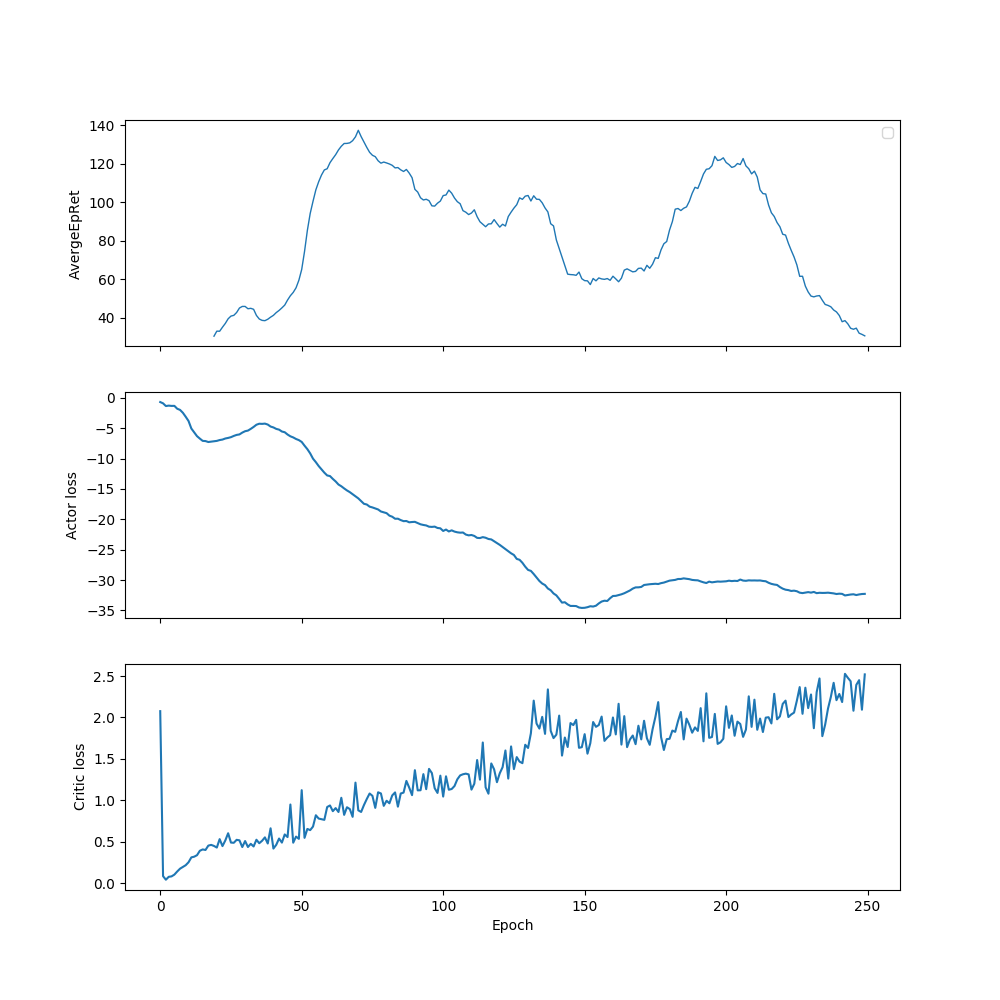

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


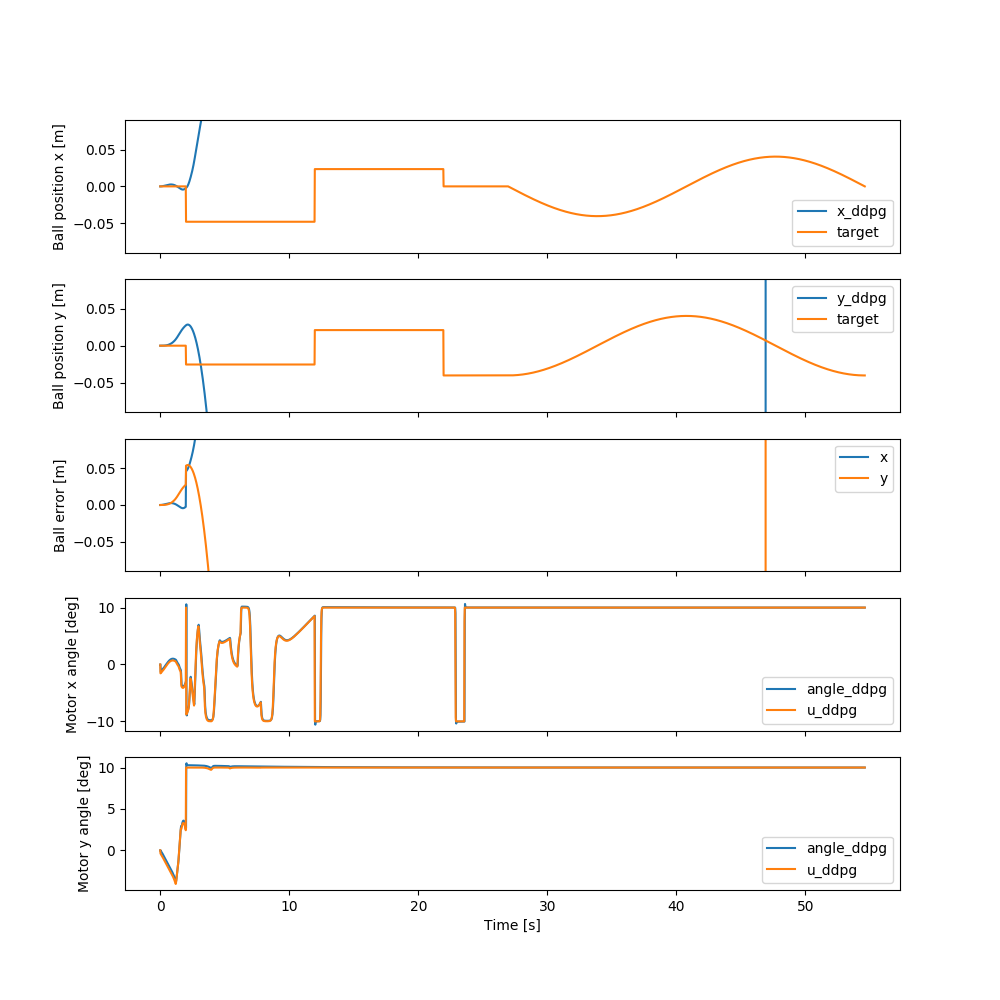

In [29]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50]
activation = torch.nn.ReLU
name='lep_0.6_[50]_relu'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0., 0.]), array([0., 0.]), array([0., 0.]))
MSE : -2726056091.934216


<IPython.core.display.Javascript object>


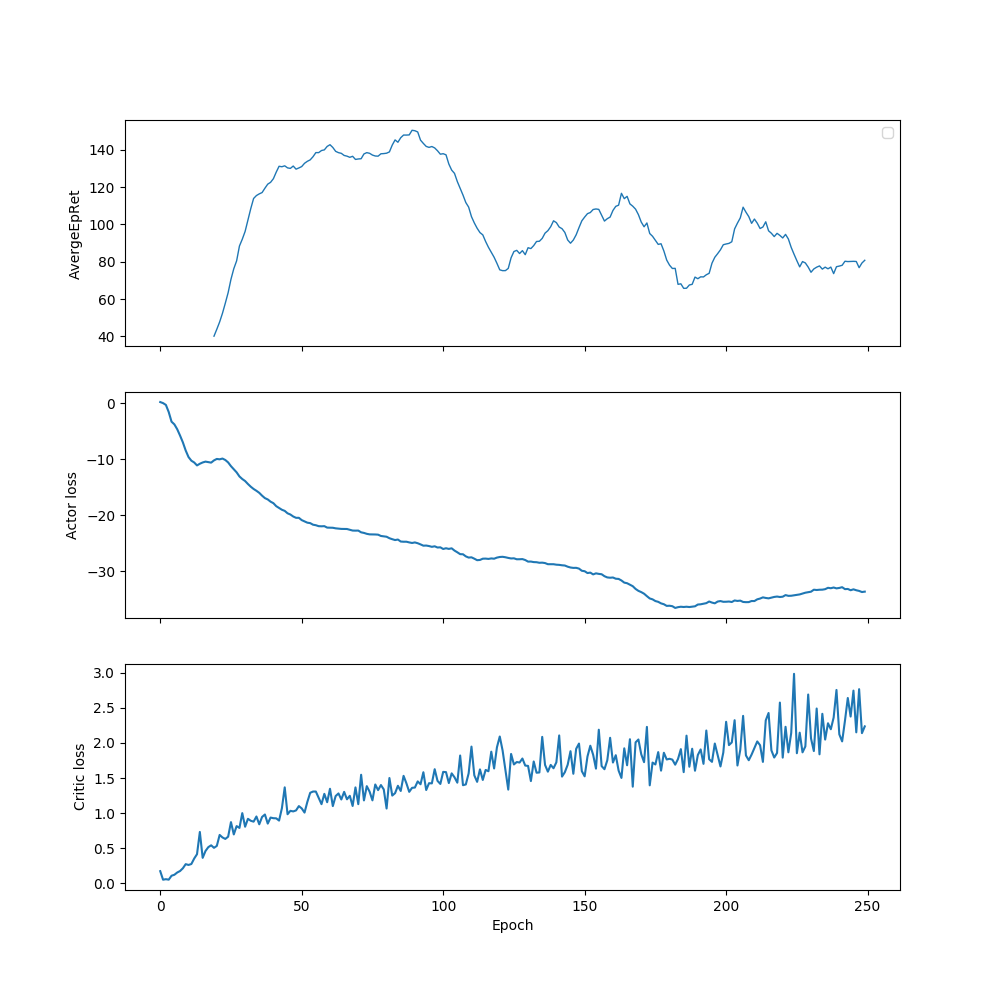

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


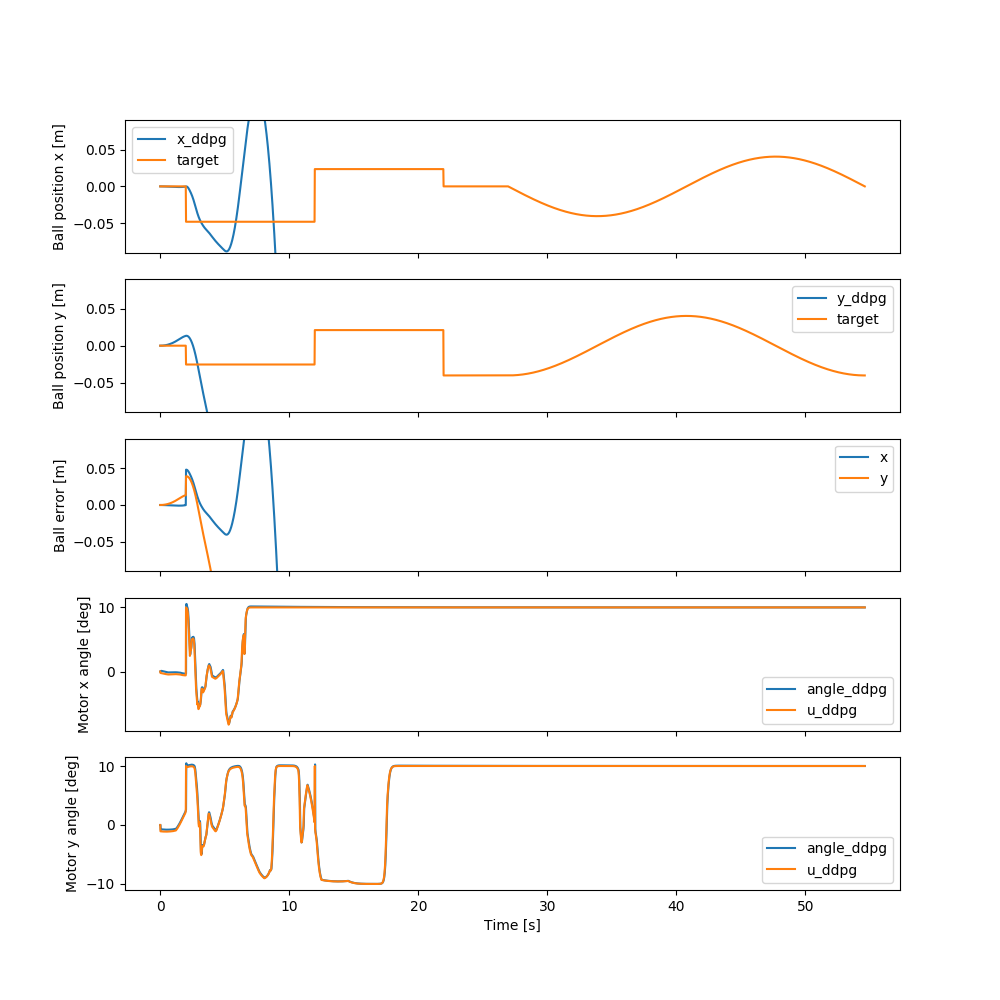

In [30]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100]
activation = torch.nn.ReLU
name='lep_0.6_[100]_relu'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

In [20]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200]
activation = torch.nn.ReLU
name='lep_0.6_[200]_relu'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

Logging data to src/data/black_box_controller_no_integral/exploratory_penality/lep_0.6_[200]_relu/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            200
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"MLPActorCritic",
    "batch_size":	100,
    "env_fn":	"create_env",
    "epochs":	250,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f09bee91f60>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/black_box_controller_no_integral/exploratory_penality/lep_0.6_[200]_relu",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/black_box_controller_no_integral/exploratory_penality/lep_0.6_[200]_relu/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
    

---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |            4.18 |
|          StdEpRet |            17.3 |
|          MaxEpRet |            28.6 |
|          MinEpRet |           -8.96 |
|  AverageTestEpRet |             145 |
|      StdTestEpRet |              12 |
|      MaxTestEpRet |             165 |
|      MinTestEpRet |             125 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         8.8e+03 |
|      AverageQVals |            4.68 |
|          StdQVals |            7.17 |
|          MaxQVals |            38.7 |
|          MinQVals |           -10.2 |
|            LossPi |           -4.87 |
|             LossQ |           0.222 |
|              Time |            47.5 |
---------------------------------------
---------------------------------------
|             Epoch |               9 |
|      AverageEpRet |            36.1 |
|          StdEpRet |            1.16 |


KeyboardInterrupt: 

In [ ]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [400]
activation = torch.nn.ReLU
name='lep_0.6_[400]_relu'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

In [ ]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50]
activation = torch.nn.Sigmoid
name='lep_0.6_[50]_sigmoid'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

In [ ]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100]
activation = torch.nn.Sigmoid
name='lep_0.6_[100]_sigmoid'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

In [ ]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200]
activation = torch.nn.Sigmoid
name='lep_0.6_[200]_sigmoid'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

In [ ]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [400]
activation = torch.nn.Sigmoid
name='lep_0.6_[400]_sigmoid'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

In [ ]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100,50]
activation = torch.nn.Sigmoid
name='lep_0.6_[100,50]_sigmoid'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

In [ ]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200,100]
activation = torch.nn.Sigmoid
name='lep_0.6_[200,100]_sigmoid'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

In [ ]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [400,200]
activation = torch.nn.Sigmoid
name='lep_0.6_[400,200]_sigmoid'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

Logging data to src/data/black_box_controller_no_integral/exploratory_penality/lep_0.6_[400,200]_sigmoid/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"Sigmoid",
        "hidden_sizes":	[
            400,
            200
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"MLPActorCritic",
    "batch_size":	100,
    "env_fn":	"create_env",
    "epochs":	250,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f09bed86208>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/black_box_controller_no_integral/exploratory_penality/lep_0.6_[400,200]_sigmoid",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/black_box_controller_no_integral/exploratory_penality/lep_0.6_[400,200]_sigmoid/progress.txt' mode='w' encoding='UTF-8'>

---------------------------------------
|             Epoch |               7 |
|      AverageEpRet |            33.7 |
|          StdEpRet |            5.11 |
|          MaxEpRet |            39.2 |
|          MinEpRet |            26.9 |
|  AverageTestEpRet |             193 |
|      StdTestEpRet |            28.7 |
|      MaxTestEpRet |             256 |
|      MinTestEpRet |             149 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         7.7e+03 |
|      AverageQVals |            6.25 |
|          StdQVals |            6.38 |
|          MaxQVals |            18.4 |
|          MinQVals |           -4.55 |
|            LossPi |           -6.44 |
|             LossQ |          0.0767 |
|              Time |             110 |
---------------------------------------
---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |            22.6 |
|          StdEpRet |            11.3 |


---------------------------------------
|             Epoch |              17 |
|      AverageEpRet |             136 |
|          StdEpRet |            20.8 |
|          MaxEpRet |             157 |
|          MinEpRet |             115 |
|  AverageTestEpRet |             171 |
|      StdTestEpRet |            40.2 |
|      MaxTestEpRet |             256 |
|      MinTestEpRet |             107 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.87e+04 |
|      AverageQVals |            15.3 |
|          StdQVals |            15.4 |
|          MaxQVals |            39.1 |
|          MinQVals |           -4.55 |
|            LossPi |           -15.6 |
|             LossQ |           0.366 |
|              Time |             335 |
---------------------------------------
---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |             170 |
|          StdEpRet |            54.5 |


---------------------------------------
|             Epoch |              27 |
|      AverageEpRet |             191 |
|          StdEpRet |            30.8 |
|          MaxEpRet |             233 |
|          MinEpRet |             159 |
|  AverageTestEpRet |             233 |
|      StdTestEpRet |            46.7 |
|      MaxTestEpRet |             296 |
|      MinTestEpRet |             100 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.97e+04 |
|      AverageQVals |            29.3 |
|          StdQVals |            20.1 |
|          MaxQVals |            52.5 |
|          MinQVals |           -5.95 |
|            LossPi |           -29.6 |
|             LossQ |           0.822 |
|              Time |             546 |
---------------------------------------
---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |             150 |
|          StdEpRet |              18 |


---------------------------------------
|             Epoch |              37 |
|      AverageEpRet |             250 |
|          StdEpRet |            11.8 |
|          MaxEpRet |             261 |
|          MinEpRet |             238 |
|  AverageTestEpRet |             223 |
|      StdTestEpRet |            23.5 |
|      MaxTestEpRet |             261 |
|      MinTestEpRet |             165 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        4.07e+04 |
|      AverageQVals |            40.4 |
|          StdQVals |            20.2 |
|          MaxQVals |            61.3 |
|          MinQVals |           -3.59 |
|            LossPi |           -40.6 |
|             LossQ |           0.845 |
|              Time |             737 |
---------------------------------------
---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |             208 |
|          StdEpRet |            30.5 |


---------------------------------------
|             Epoch |              47 |
|      AverageEpRet |             224 |
|          StdEpRet |            17.7 |
|          MaxEpRet |             244 |
|          MinEpRet |             201 |
|  AverageTestEpRet |             216 |
|      StdTestEpRet |            27.2 |
|      MaxTestEpRet |             249 |
|      MinTestEpRet |             154 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        5.17e+04 |
|      AverageQVals |            46.6 |
|          StdQVals |            20.2 |
|          MaxQVals |            64.5 |
|          MinQVals |           -4.82 |
|            LossPi |           -46.8 |
|             LossQ |           0.885 |
|              Time |             947 |
---------------------------------------
---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |             190 |
|          StdEpRet |            40.4 |


---------------------------------------
|             Epoch |              57 |
|      AverageEpRet |             183 |
|          StdEpRet |            19.6 |
|          MaxEpRet |             203 |
|          MinEpRet |             164 |
|  AverageTestEpRet |             244 |
|      StdTestEpRet |            21.2 |
|      MaxTestEpRet |             285 |
|      MinTestEpRet |             209 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        6.27e+04 |
|      AverageQVals |            50.6 |
|          StdQVals |              19 |
|          MaxQVals |            66.7 |
|          MinQVals |           -2.45 |
|            LossPi |           -50.8 |
|             LossQ |            1.04 |
|              Time |        1.16e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |             242 |
|          StdEpRet |            45.1 |


---------------------------------------
|             Epoch |              67 |
|      AverageEpRet |             205 |
|          StdEpRet |            27.3 |
|          MaxEpRet |             240 |
|          MinEpRet |             174 |
|  AverageTestEpRet |             221 |
|      StdTestEpRet |            21.8 |
|      MaxTestEpRet |             266 |
|      MinTestEpRet |             182 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        7.37e+04 |
|      AverageQVals |            53.4 |
|          StdQVals |            19.1 |
|          MaxQVals |            68.9 |
|          MinQVals |           -6.47 |
|            LossPi |           -53.6 |
|             LossQ |            1.02 |
|              Time |        1.36e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |             214 |
|          StdEpRet |            15.7 |


---------------------------------------
|             Epoch |              77 |
|      AverageEpRet |             231 |
|          StdEpRet |            6.05 |
|          MaxEpRet |             237 |
|          MinEpRet |             225 |
|  AverageTestEpRet |             235 |
|      StdTestEpRet |            34.7 |
|      MaxTestEpRet |             297 |
|      MinTestEpRet |             179 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        8.47e+04 |
|      AverageQVals |            55.5 |
|          StdQVals |            18.1 |
|          MaxQVals |            69.6 |
|          MinQVals |           -3.16 |
|            LossPi |           -55.6 |
|             LossQ |           0.792 |
|              Time |        1.54e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |             203 |
|          StdEpRet |            47.6 |


---------------------------------------
|             Epoch |              87 |
|      AverageEpRet |             259 |
|          StdEpRet |              20 |
|          MaxEpRet |             287 |
|          MinEpRet |             243 |
|  AverageTestEpRet |             227 |
|      StdTestEpRet |            28.2 |
|      MaxTestEpRet |             278 |
|      MinTestEpRet |             161 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        9.57e+04 |
|      AverageQVals |              57 |
|          StdQVals |            16.8 |
|          MaxQVals |            69.5 |
|          MinQVals |           -5.18 |
|            LossPi |           -57.1 |
|             LossQ |           0.912 |
|              Time |        1.74e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |             226 |
|          StdEpRet |            31.4 |


---------------------------------------
|             Epoch |              97 |
|      AverageEpRet |             231 |
|          StdEpRet |            8.23 |
|          MaxEpRet |             239 |
|          MinEpRet |             223 |
|  AverageTestEpRet |             252 |
|      StdTestEpRet |              42 |
|      MaxTestEpRet |             307 |
|      MinTestEpRet |             165 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.07e+05 |
|      AverageQVals |              58 |
|          StdQVals |            15.7 |
|          MaxQVals |            69.5 |
|          MinQVals |           -4.97 |
|            LossPi |           -58.1 |
|             LossQ |           0.863 |
|              Time |        1.96e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |             250 |
|          StdEpRet |            19.5 |


---------------------------------------
|             Epoch |             107 |
|      AverageEpRet |             210 |
|          StdEpRet |            54.2 |
|          MaxEpRet |             260 |
|          MinEpRet |             135 |
|  AverageTestEpRet |             239 |
|      StdTestEpRet |            31.9 |
|      MaxTestEpRet |             296 |
|      MinTestEpRet |             190 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.18e+05 |
|      AverageQVals |            58.4 |
|          StdQVals |            15.4 |
|          MaxQVals |            69.5 |
|          MinQVals |           -5.56 |
|            LossPi |           -58.5 |
|             LossQ |           0.859 |
|              Time |        2.17e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             108 |
|      AverageEpRet |             207 |
|          StdEpRet |            25.8 |


---------------------------------------
|             Epoch |             117 |
|      AverageEpRet |             202 |
|          StdEpRet |            2.77 |
|          MaxEpRet |             204 |
|          MinEpRet |             199 |
|  AverageTestEpRet |             228 |
|      StdTestEpRet |            28.7 |
|      MaxTestEpRet |             287 |
|      MinTestEpRet |             174 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.29e+05 |
|      AverageQVals |            58.4 |
|          StdQVals |            14.1 |
|          MaxQVals |            68.9 |
|          MinQVals |           -3.93 |
|            LossPi |           -58.5 |
|             LossQ |           0.829 |
|              Time |        2.38e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             118 |
|      AverageEpRet |             219 |
|          StdEpRet |            27.4 |


---------------------------------------
|             Epoch |             127 |
|      AverageEpRet |             205 |
|          StdEpRet |            10.1 |
|          MaxEpRet |             219 |
|          MinEpRet |             195 |
|  AverageTestEpRet |             226 |
|      StdTestEpRet |            27.5 |
|      MaxTestEpRet |             263 |
|      MinTestEpRet |             180 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         1.4e+05 |
|      AverageQVals |            58.8 |
|          StdQVals |            13.7 |
|          MaxQVals |            68.9 |
|          MinQVals |           0.945 |
|            LossPi |           -58.9 |
|             LossQ |           0.786 |
|              Time |        2.58e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             128 |
|      AverageEpRet |             215 |
|          StdEpRet |            20.5 |


---------------------------------------
|             Epoch |             137 |
|      AverageEpRet |             207 |
|          StdEpRet |            2.77 |
|          MaxEpRet |             210 |
|          MinEpRet |             205 |
|  AverageTestEpRet |             246 |
|      StdTestEpRet |            31.9 |
|      MaxTestEpRet |             316 |
|      MinTestEpRet |             201 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.51e+05 |
|      AverageQVals |            59.2 |
|          StdQVals |            13.7 |
|          MaxQVals |            69.6 |
|          MinQVals |           -2.67 |
|            LossPi |           -59.3 |
|             LossQ |           0.917 |
|              Time |        2.79e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             138 |
|      AverageEpRet |             231 |
|          StdEpRet |              23 |


---------------------------------------
|             Epoch |             147 |
|      AverageEpRet |             228 |
|          StdEpRet |            16.2 |
|          MaxEpRet |             251 |
|          MinEpRet |             213 |
|  AverageTestEpRet |             210 |
|      StdTestEpRet |            30.4 |
|      MaxTestEpRet |             250 |
|      MinTestEpRet |             106 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.62e+05 |
|      AverageQVals |            59.9 |
|          StdQVals |            13.8 |
|          MaxQVals |            69.5 |
|          MinQVals |           -4.28 |
|            LossPi |           -60.1 |
|             LossQ |            1.02 |
|              Time |        2.99e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             148 |
|      AverageEpRet |             215 |
|          StdEpRet |            25.6 |


In [ ]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100,50,25]
activation = torch.nn.Sigmoid
name='lep_0.6_[100,50,25]_sigmoid'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

In [ ]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200,100,50]
activation = torch.nn.Sigmoid
name='lep_0.6_[200,100,50]_sigmoid'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0., 0.]), array([0., 0.]), array([0., 0.]))
MSE : -0.00041462215153634756


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


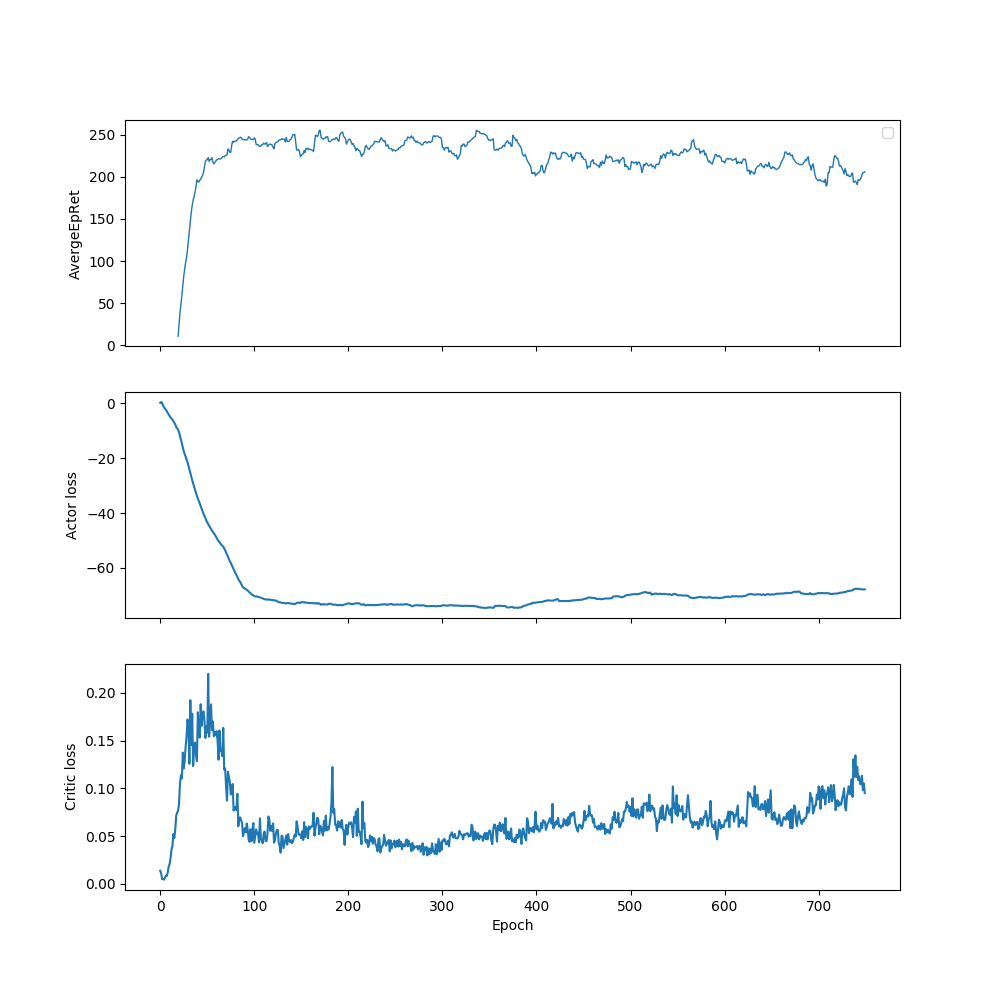

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


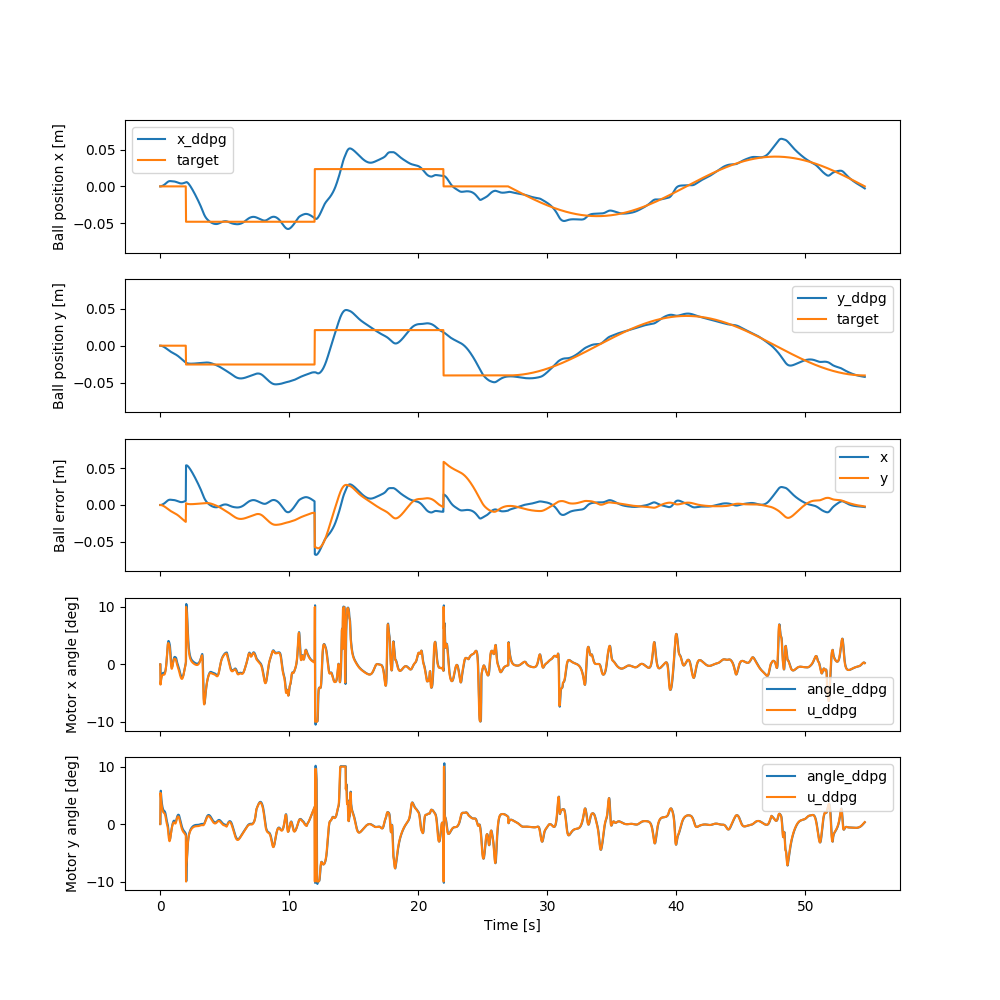

In [22]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200,100]
activation = torch.nn.Sigmoid
name='lep_0.6_[200,100]_sigmoid_long'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0., 0.]), array([0., 0.]), array([0., 0.]))
MSE : -0.0002727100616084898


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


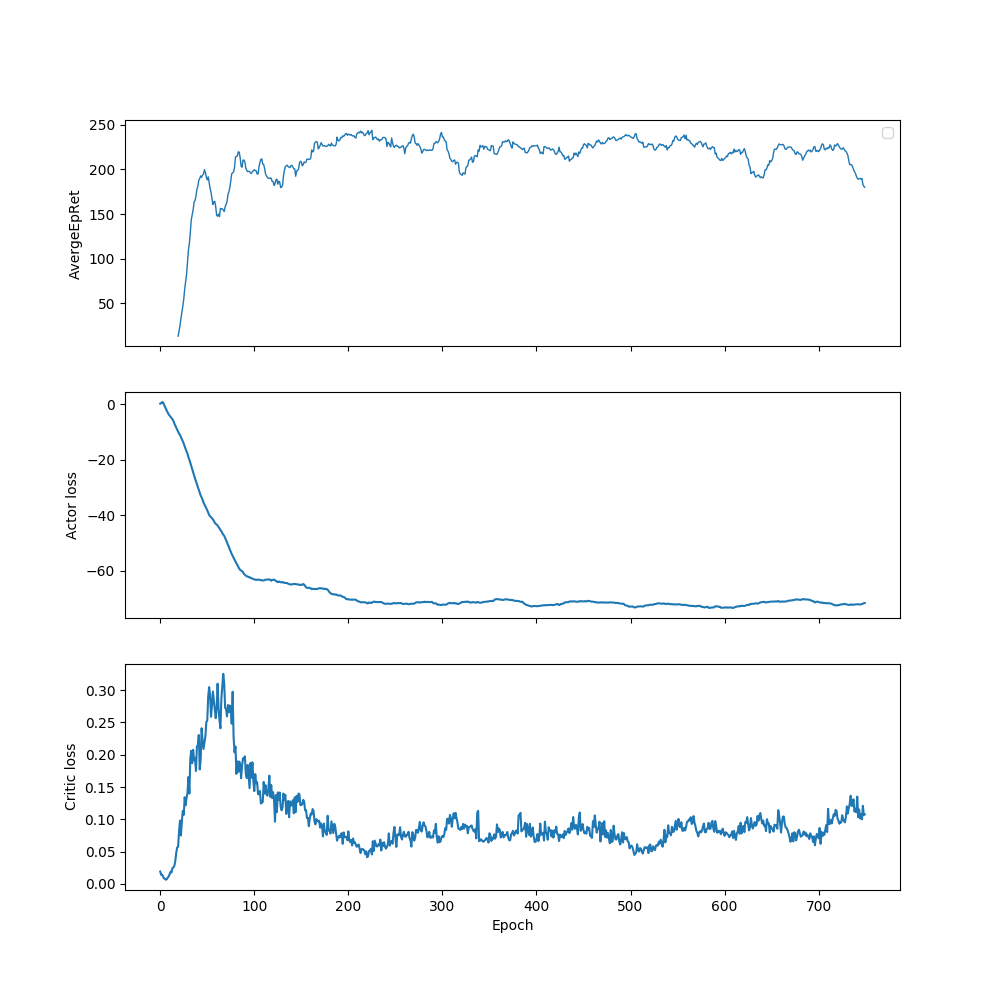

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


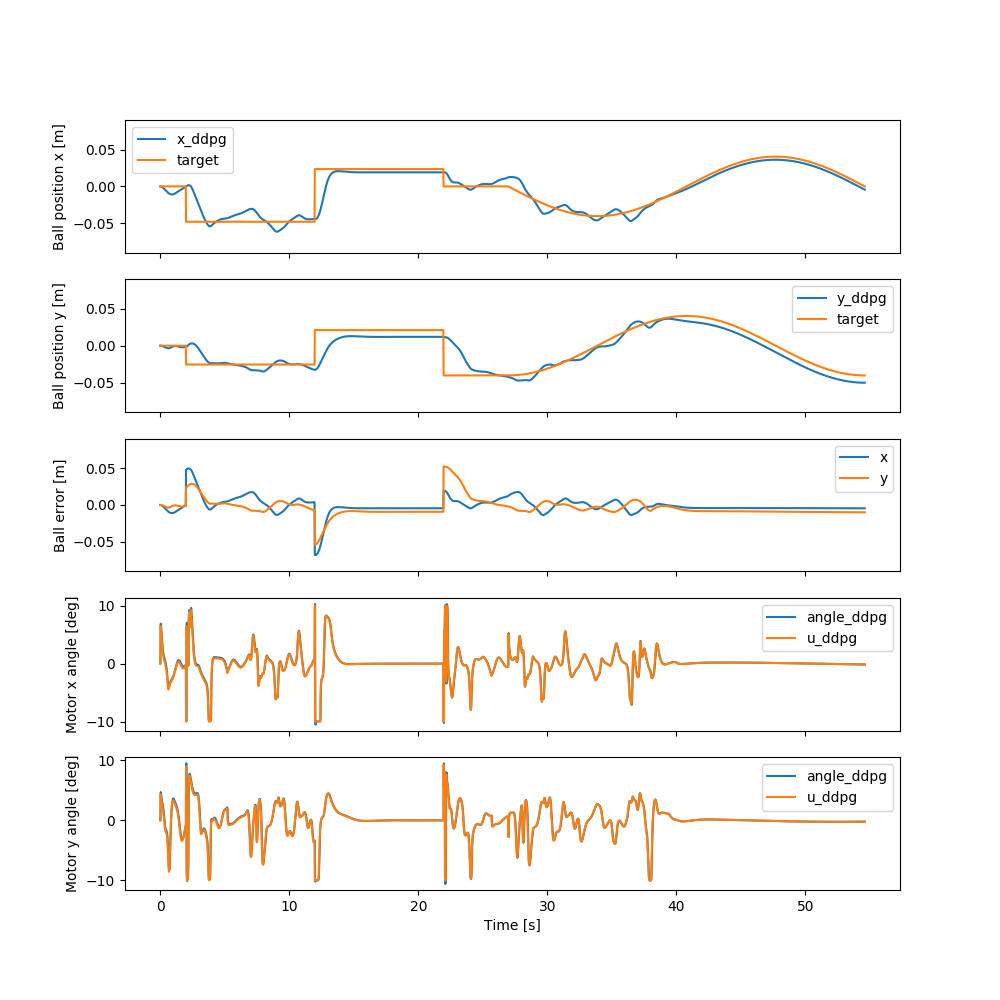

In [23]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100,50,25]
activation = torch.nn.Sigmoid
name='lep_0.6_[100,50,25]_sigmoid_long'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0., 0.]), array([0., 0.]), array([0., 0.]))
MSE : -0.00048603328906283907


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


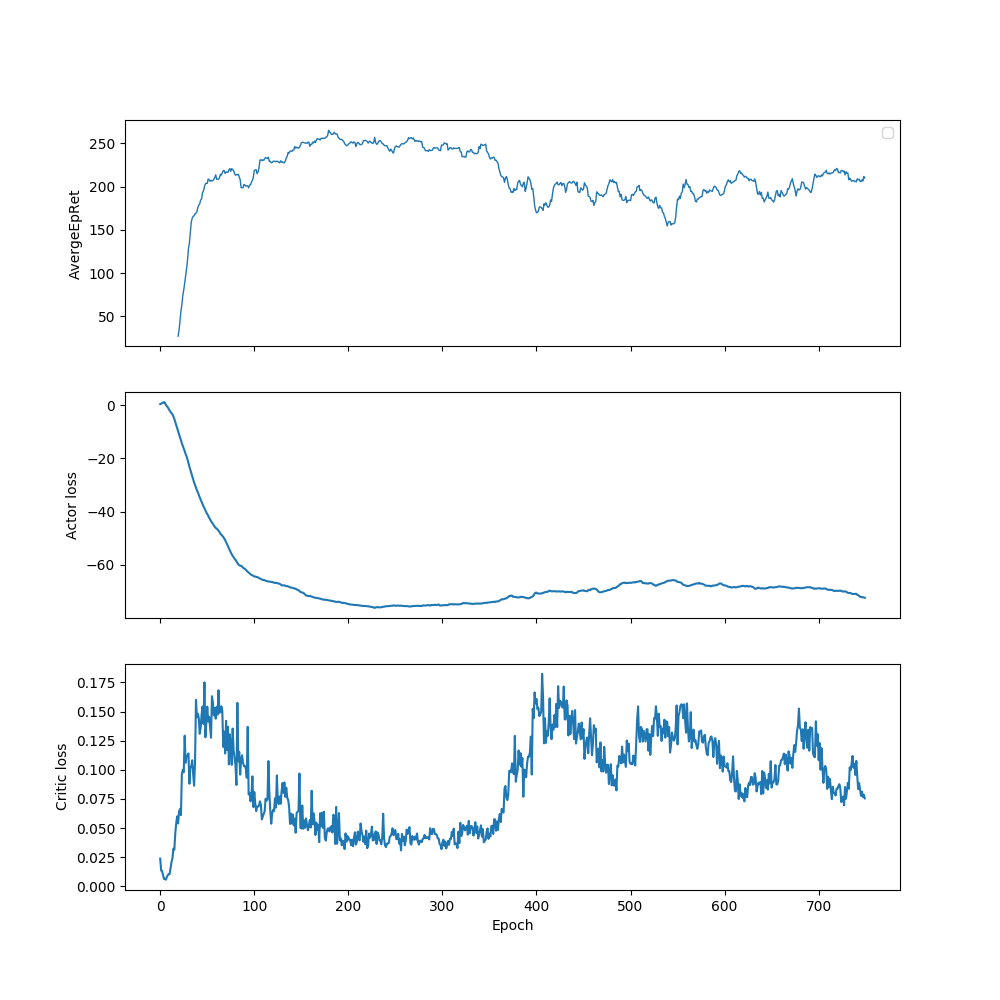

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


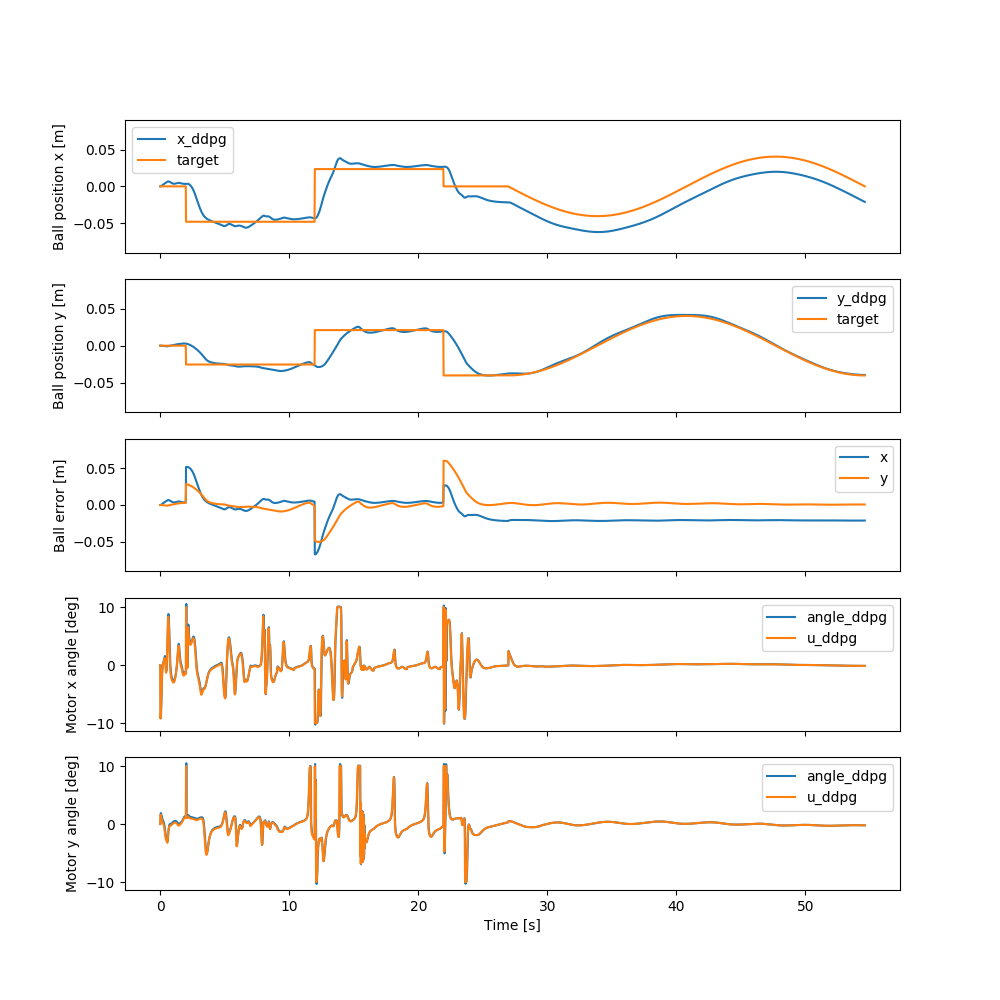

In [24]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200,100,50]
activation = torch.nn.Sigmoid
name='lep_0.6_[200,100,50]_sigmoid_long'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0., 0.]), array([0., 0.]), array([0., 0.]))
MSE : -0.00022008285148698134


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


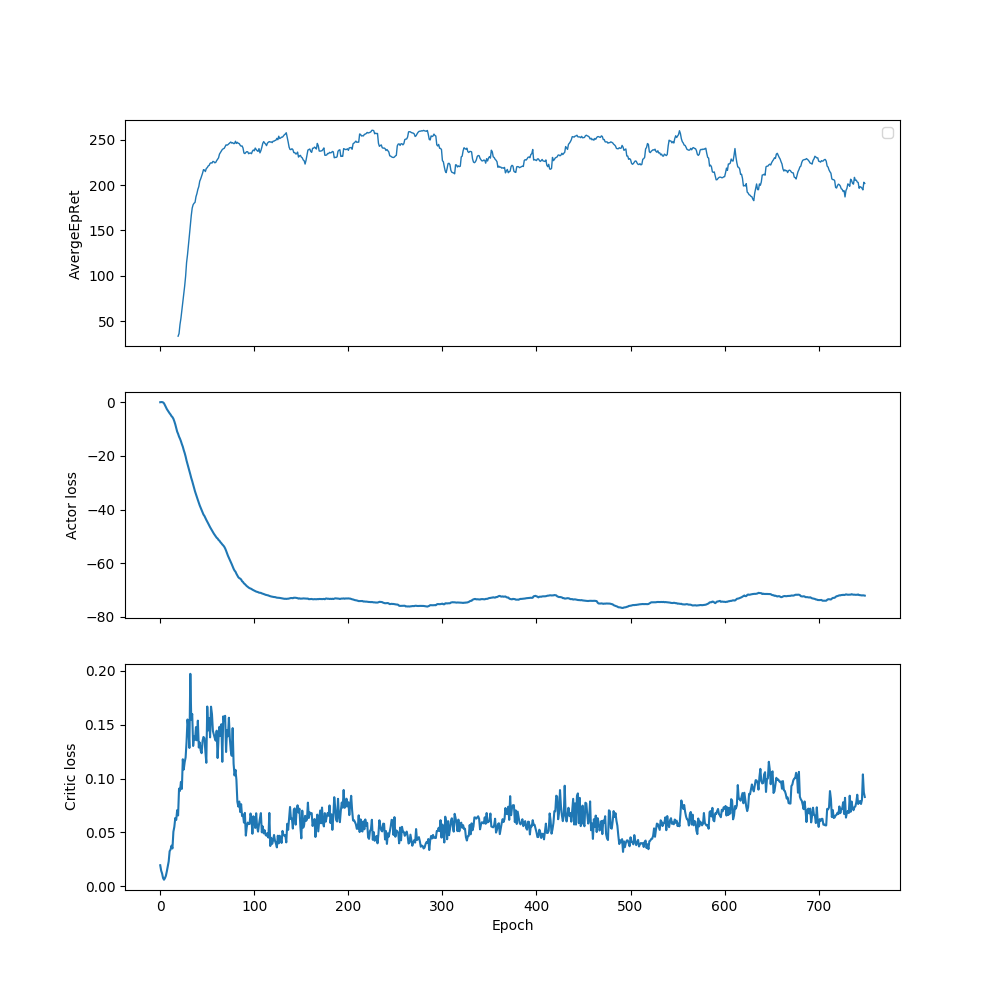

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


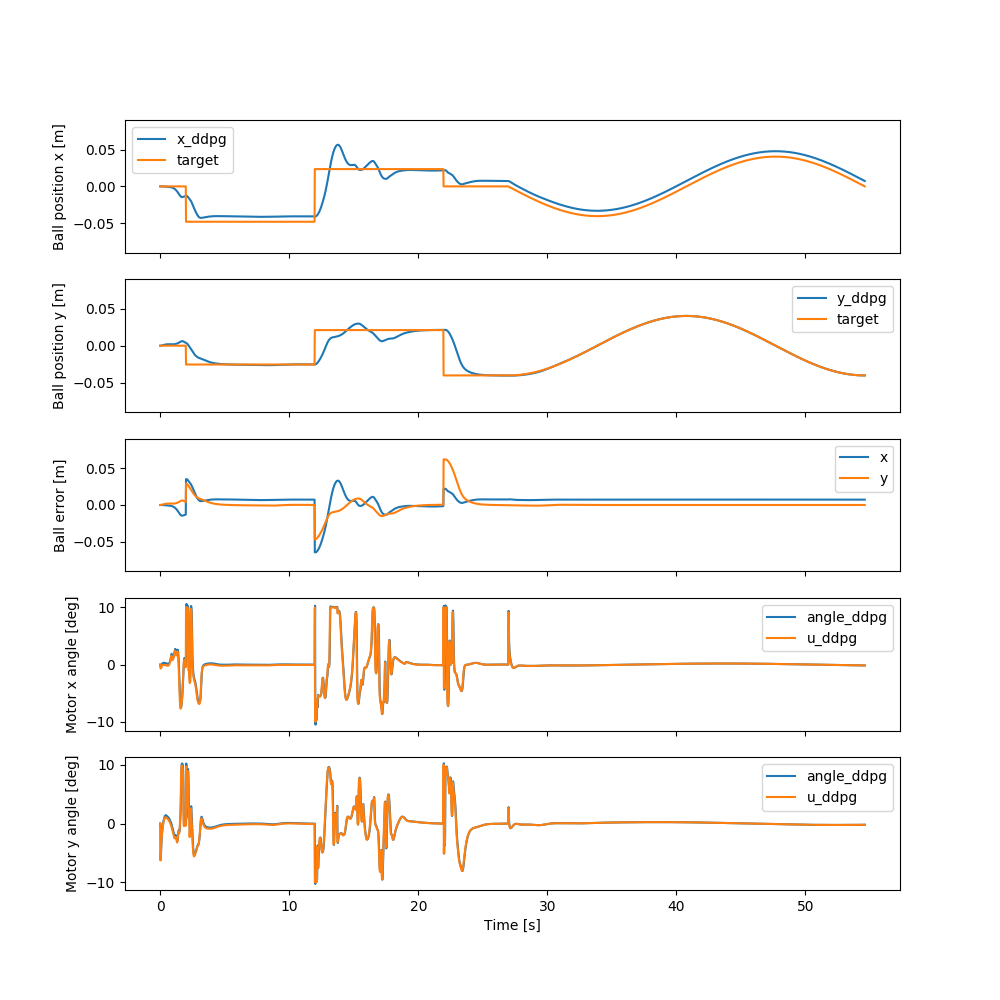

In [25]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200,200,100]
activation = torch.nn.Sigmoid
name='lep_0.6_[200,200,100]_sigmoid_long'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0., 0.]), array([0., 0.]), array([0., 0.]))
MSE : -0.0003703732055775561


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


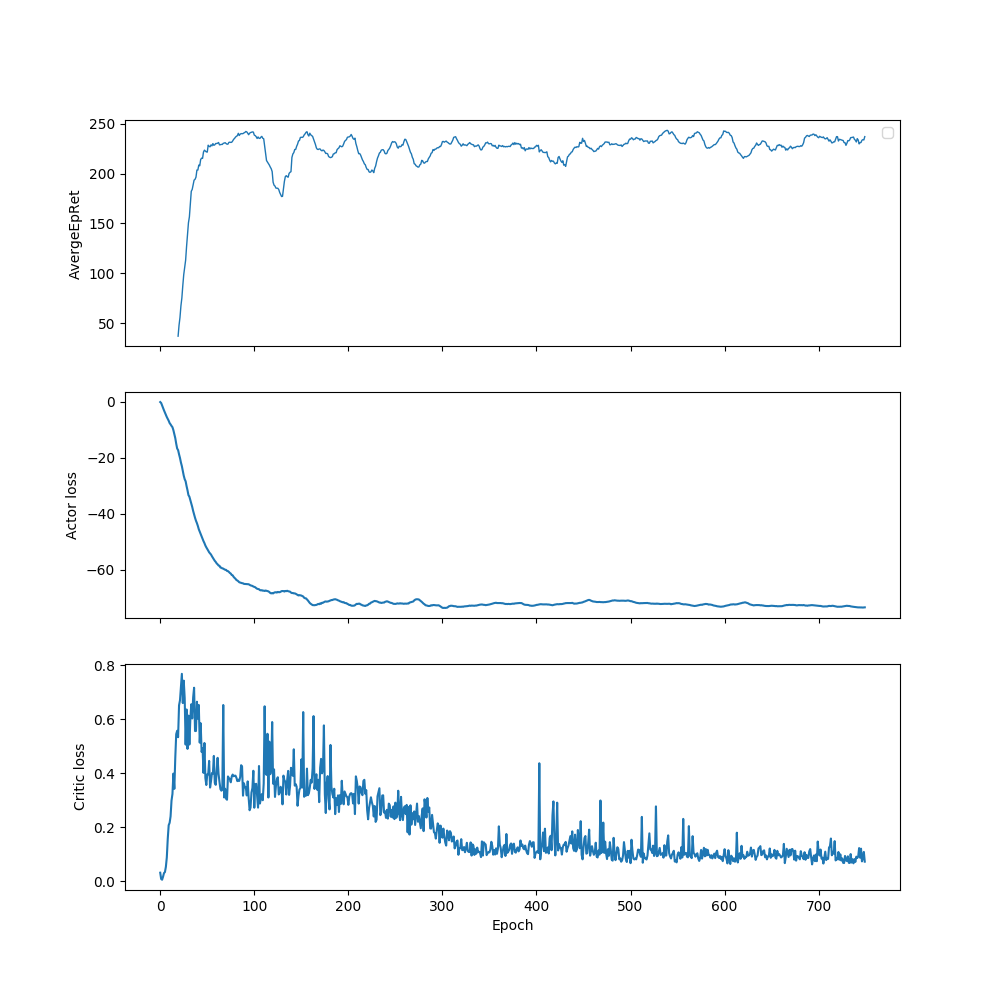

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


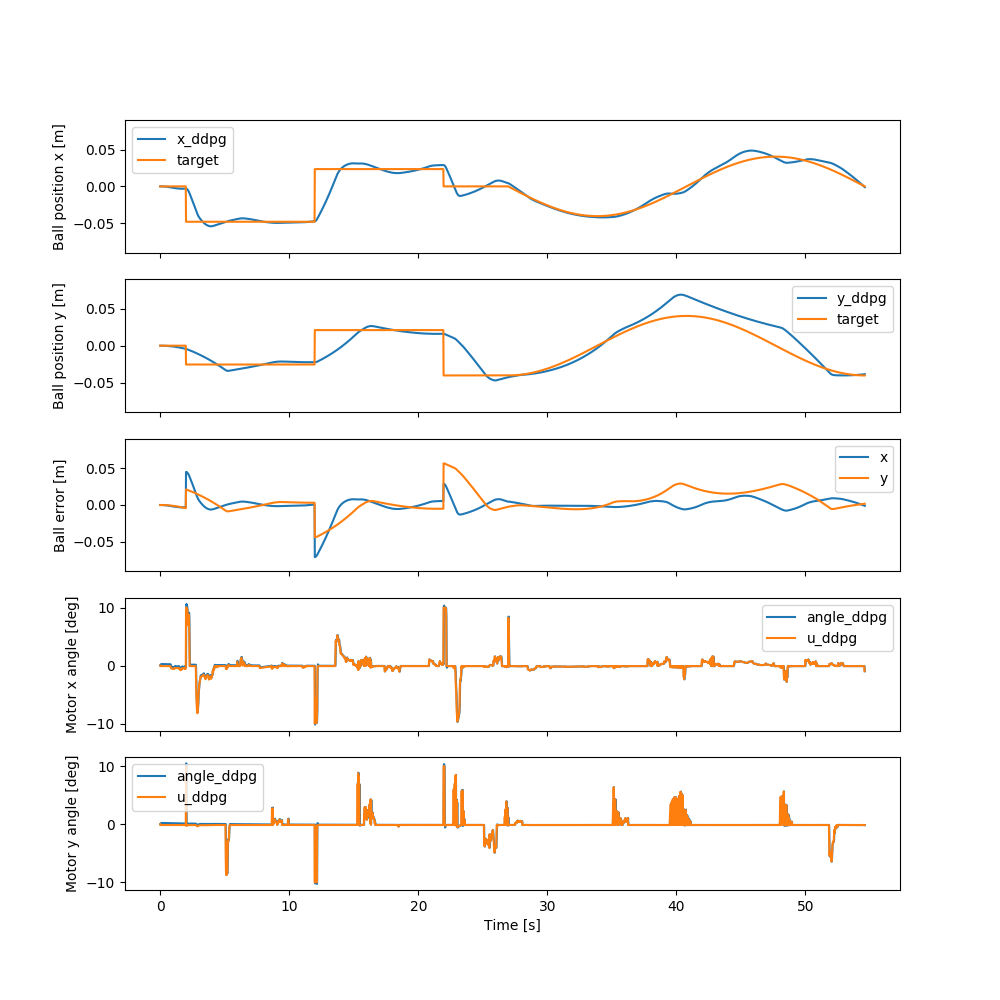

In [26]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200,200,100]
activation = torch.nn.ReLU
name='lep_0.6_[200,200,100]_relu_long'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0., 0.]), array([0., 0.]), array([0., 0.]))
MSE : -0.00030203275924854873


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


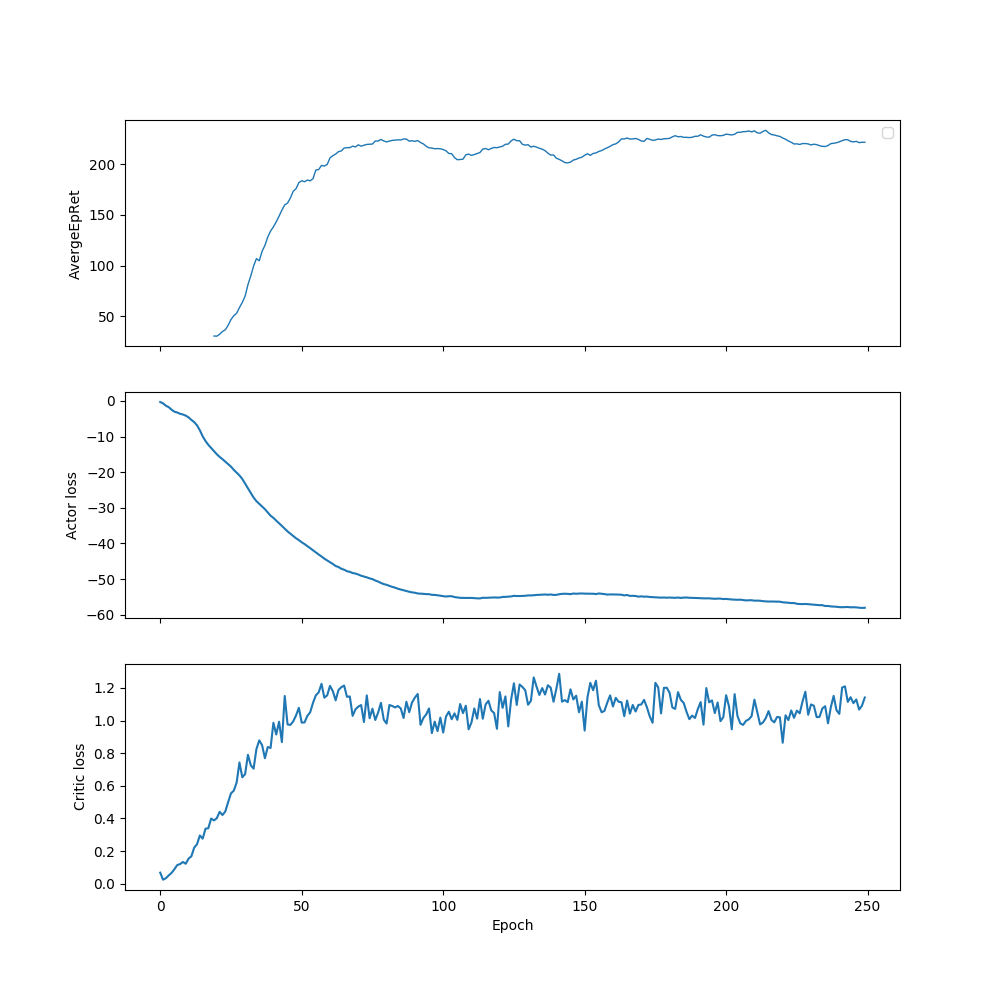

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


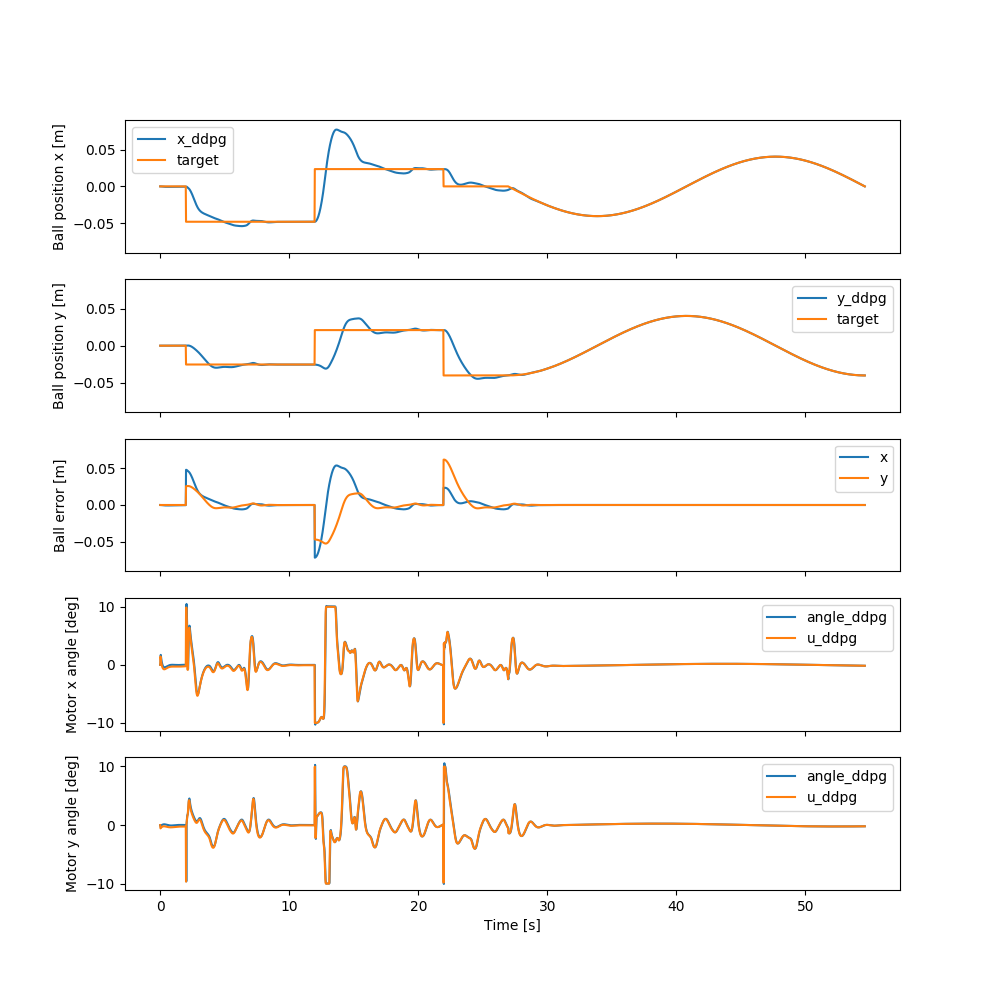

In [27]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100,50]
activation = torch.nn.Sigmoid
name='lep_0.6_[100,50]_sigmoid_hard'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0., 0.]), array([0., 0.]), array([0., 0.]))
MSE : -0.00033188190608289113


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


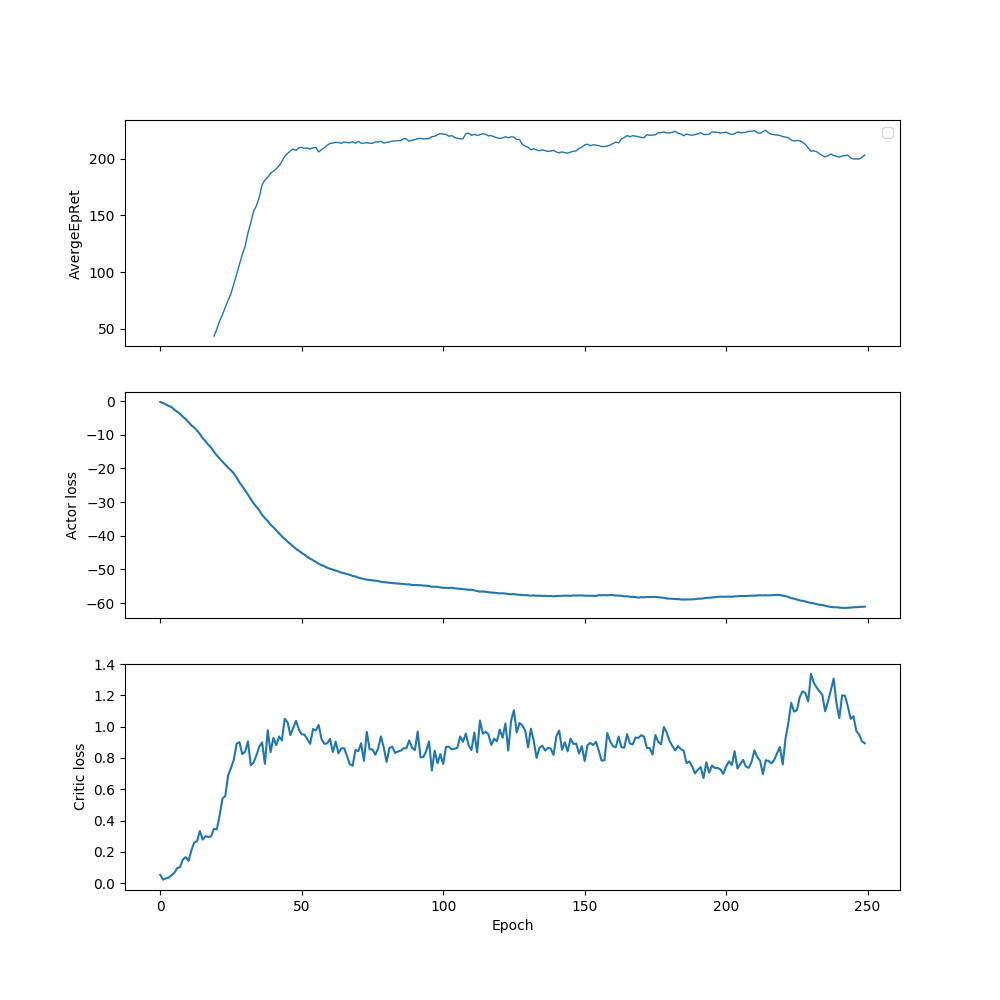

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


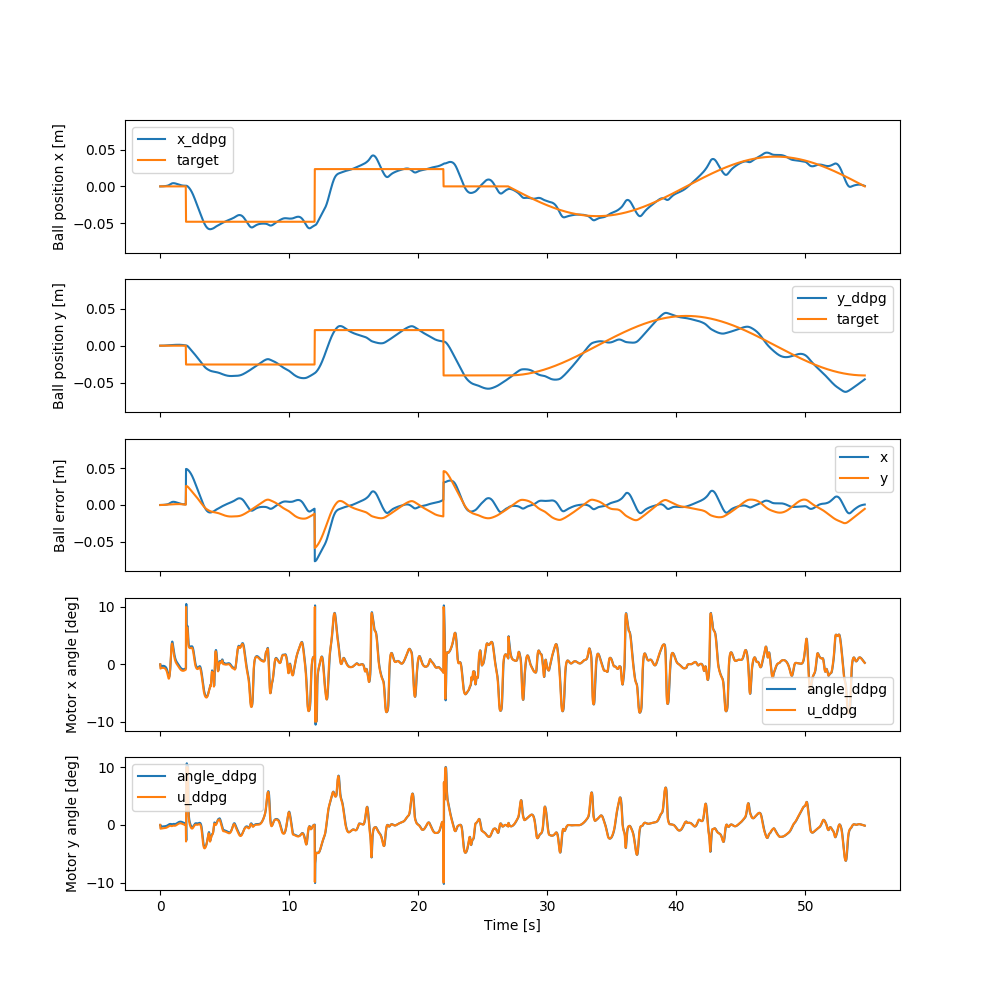

In [28]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [400,200]
activation = torch.nn.Sigmoid
name='lep_0.6_[400,200]_sigmoid_hard'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0., 0.]), array([0., 0.]), array([0., 0.]))
MSE : -0.0002938316299979435


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


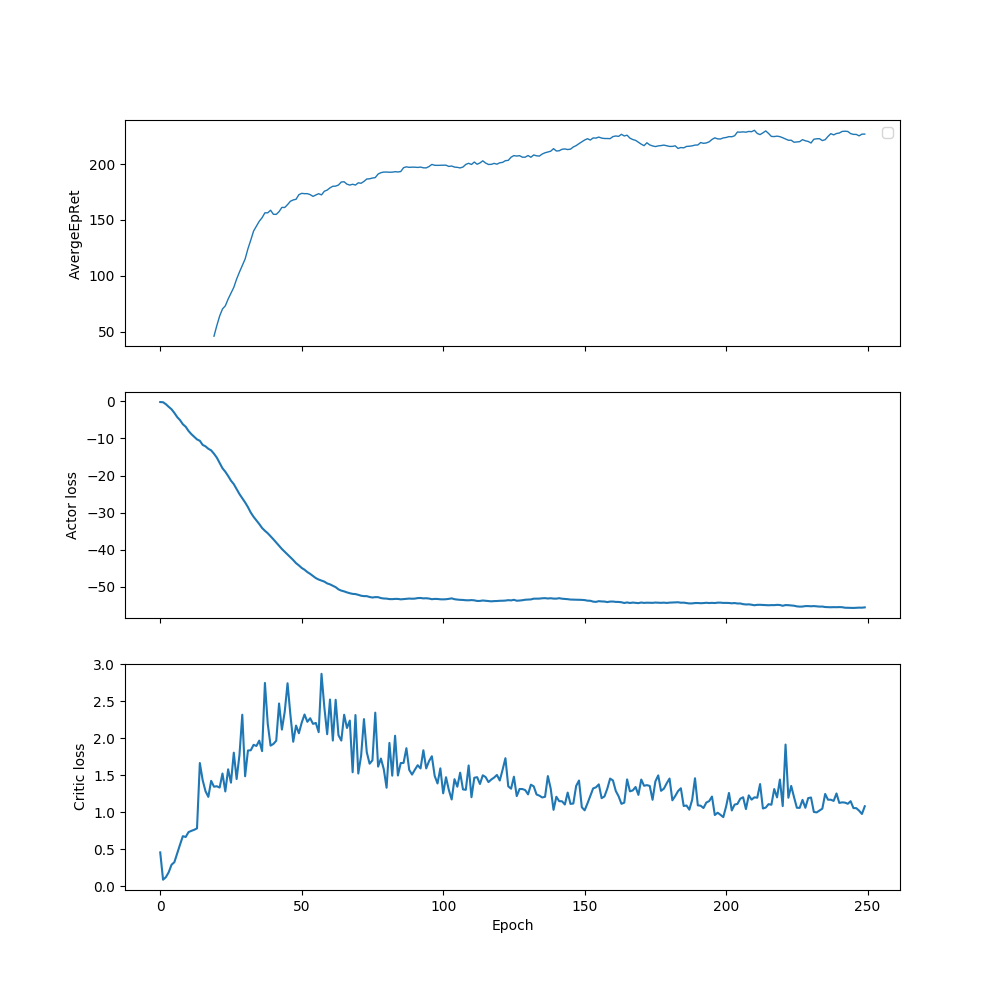

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


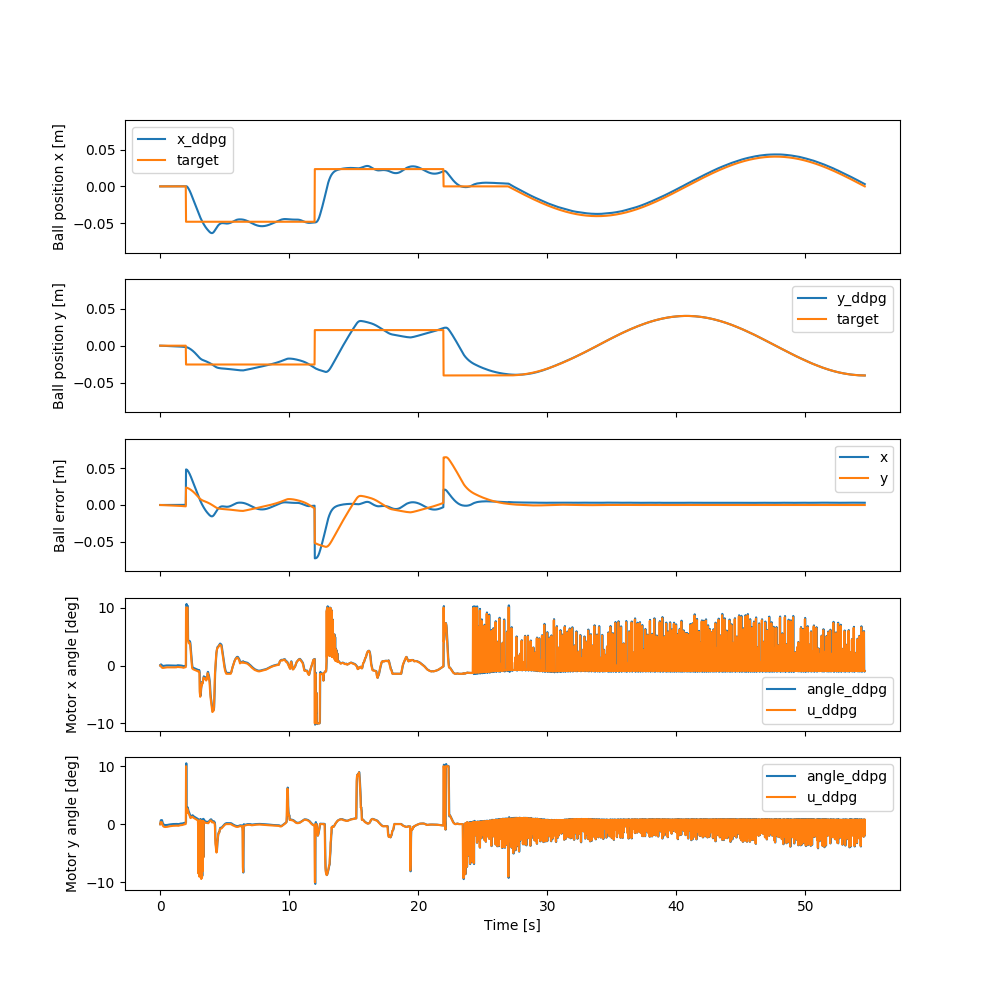

In [29]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [400,200]
activation = torch.nn.ReLU
name='lep_0.6_[400,200]_relu_hard'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0., 0.]), array([0., 0.]), array([0., 0.]))
MSE : -0.00032970034464724167


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


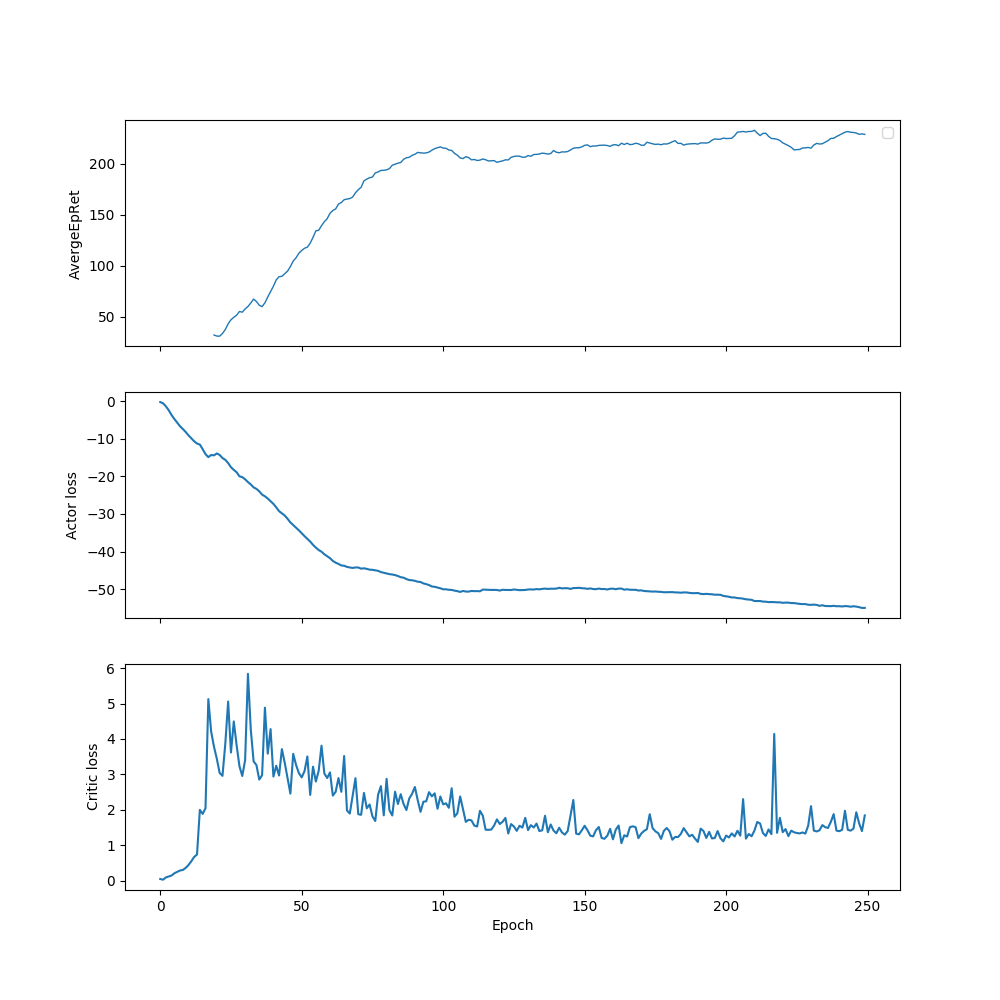

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


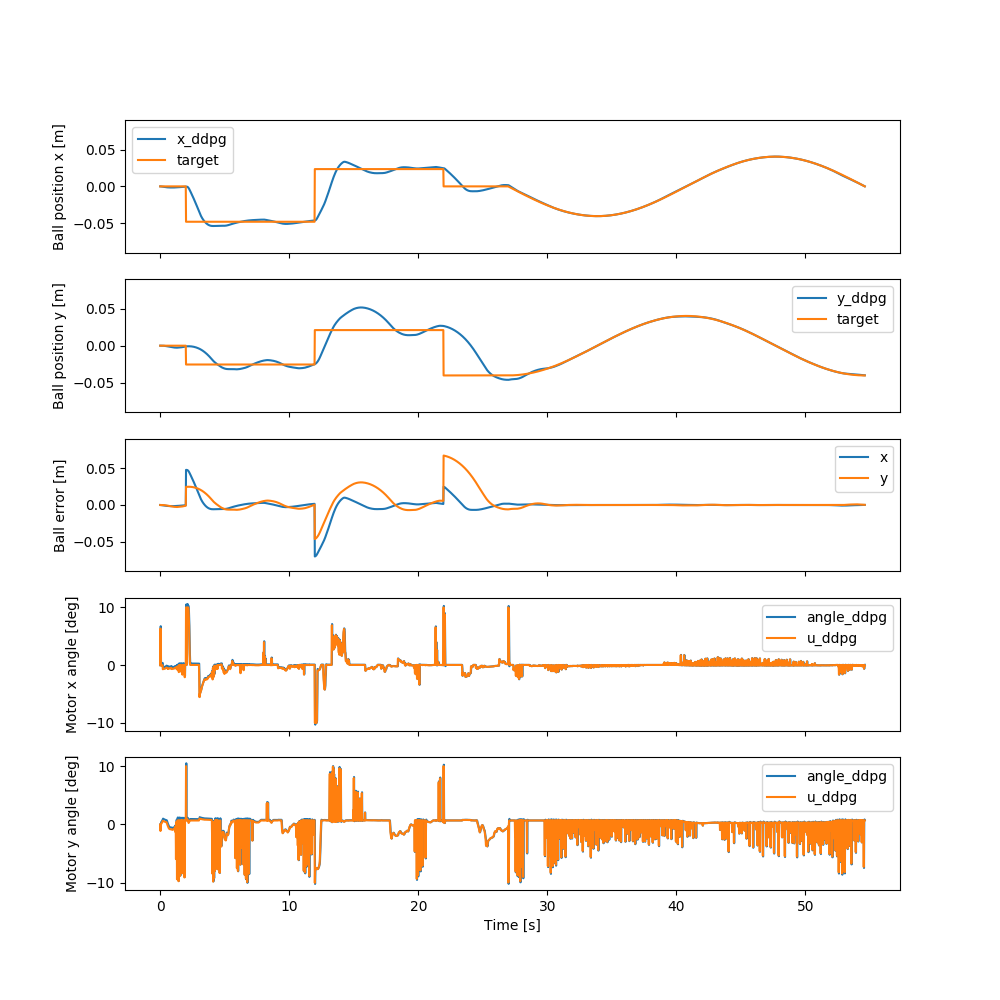

In [30]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200,200,100]
activation = torch.nn.ReLU
name='lep_0.6_[200,200,100]_relu_hard'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0., 0.]), array([0., 0.]), array([0., 0.]))
MSE : -0.000353101073062777


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


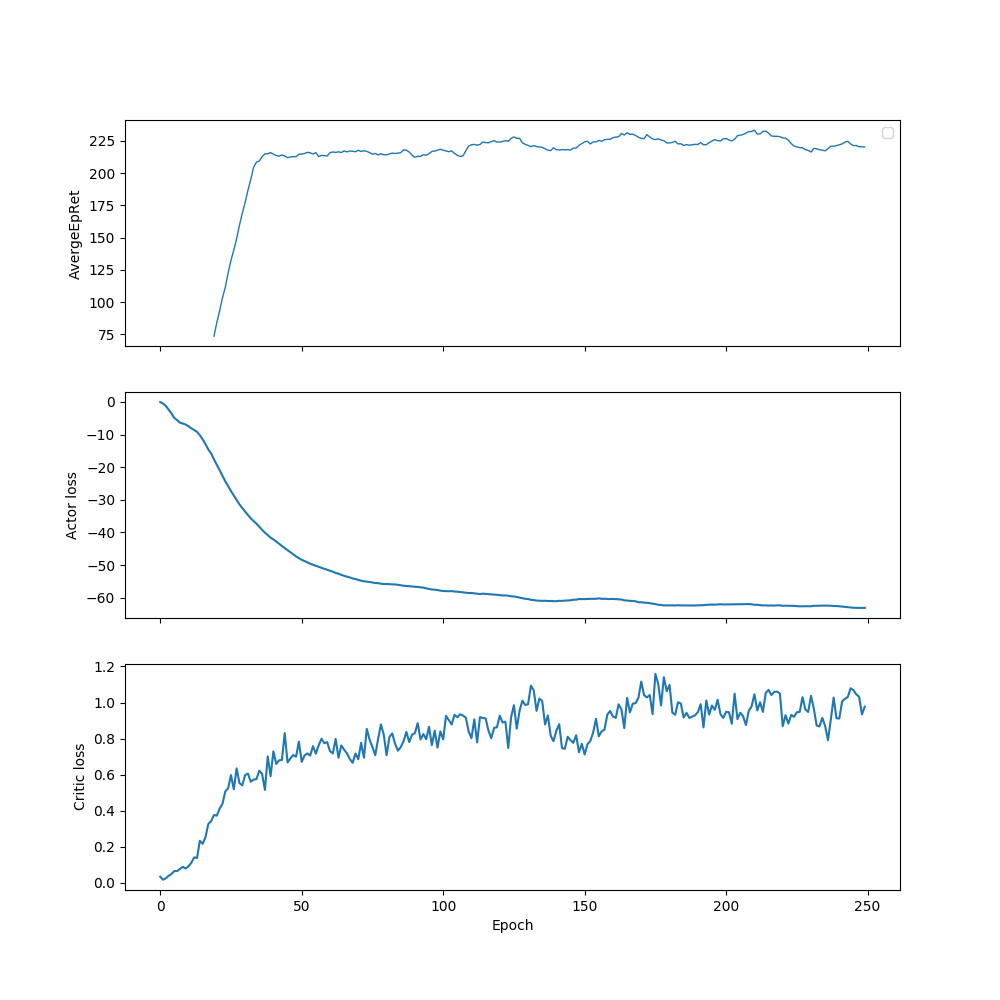

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


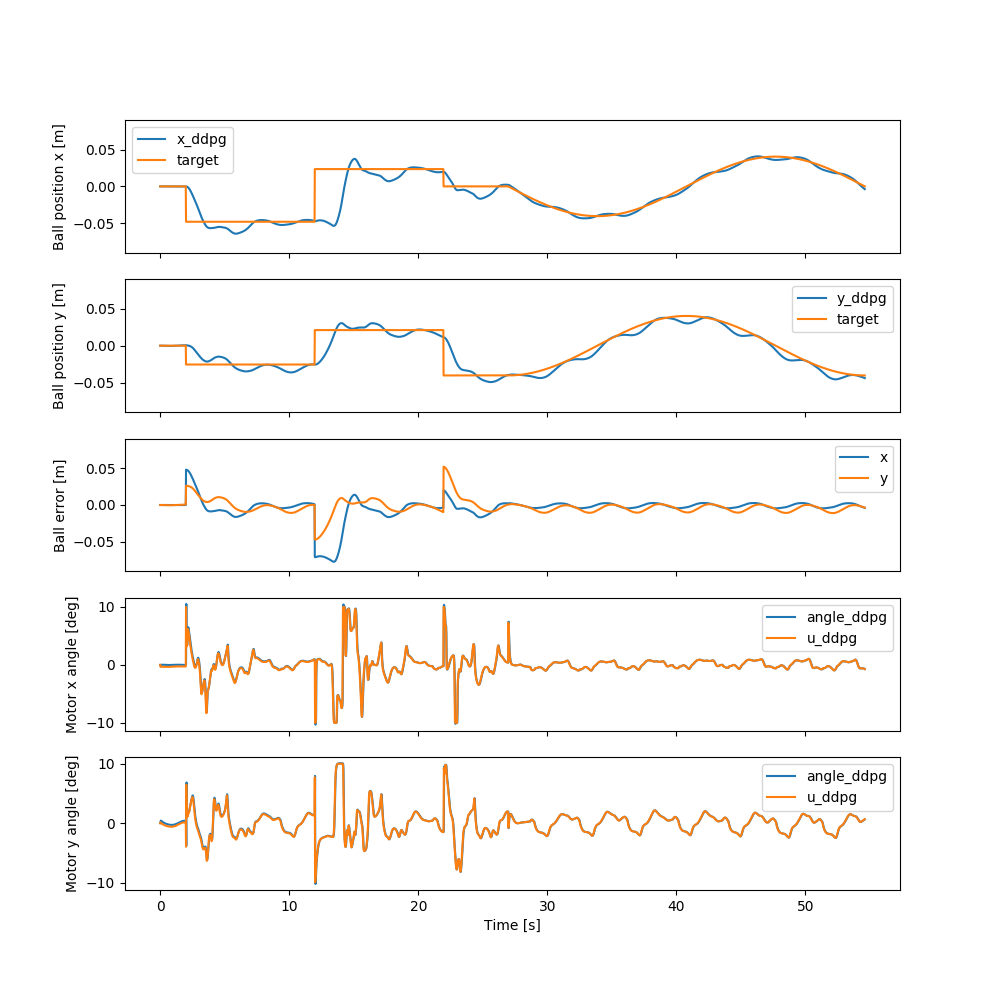

In [31]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200,200,100]
activation = torch.nn.Sigmoid
name='lep_0.6_[200,200,100]_sigmoid_hard'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0., 0.]), array([0., 0.]), array([0., 0.]))
MSE : -0.0018511138001847446


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


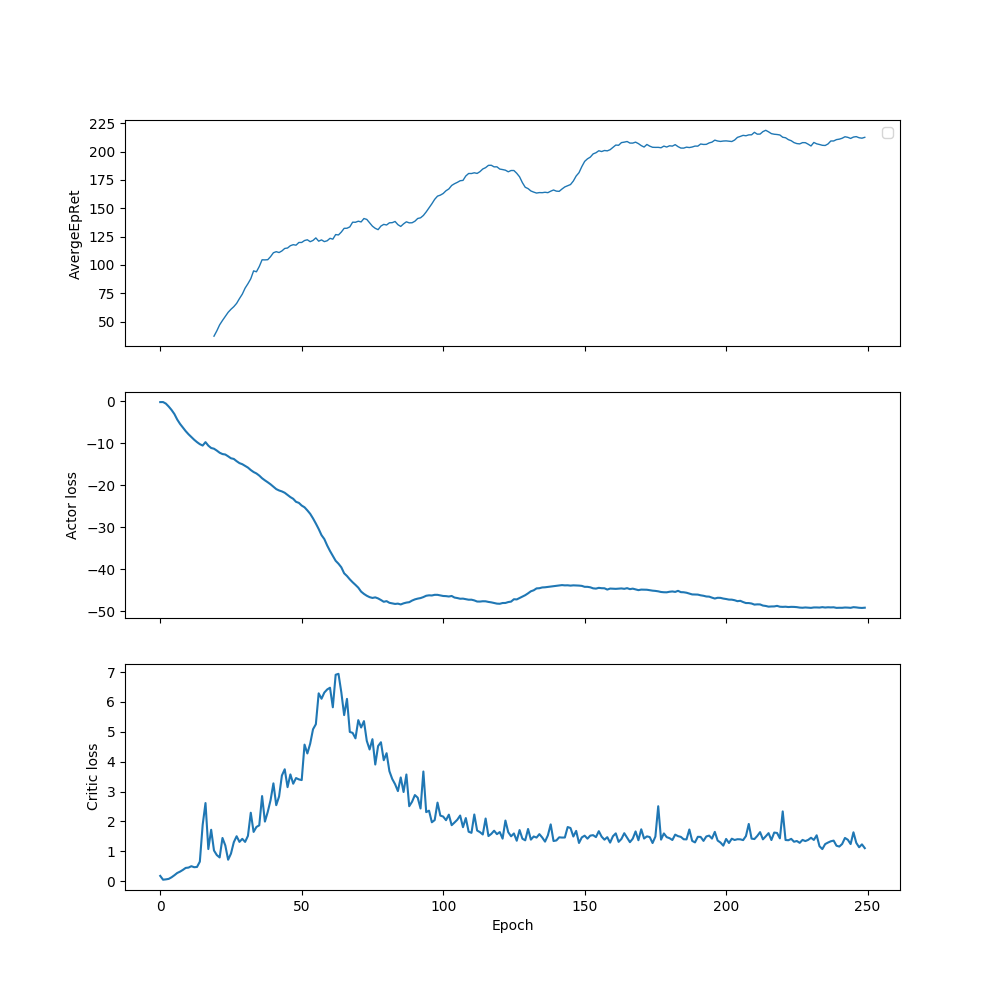

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


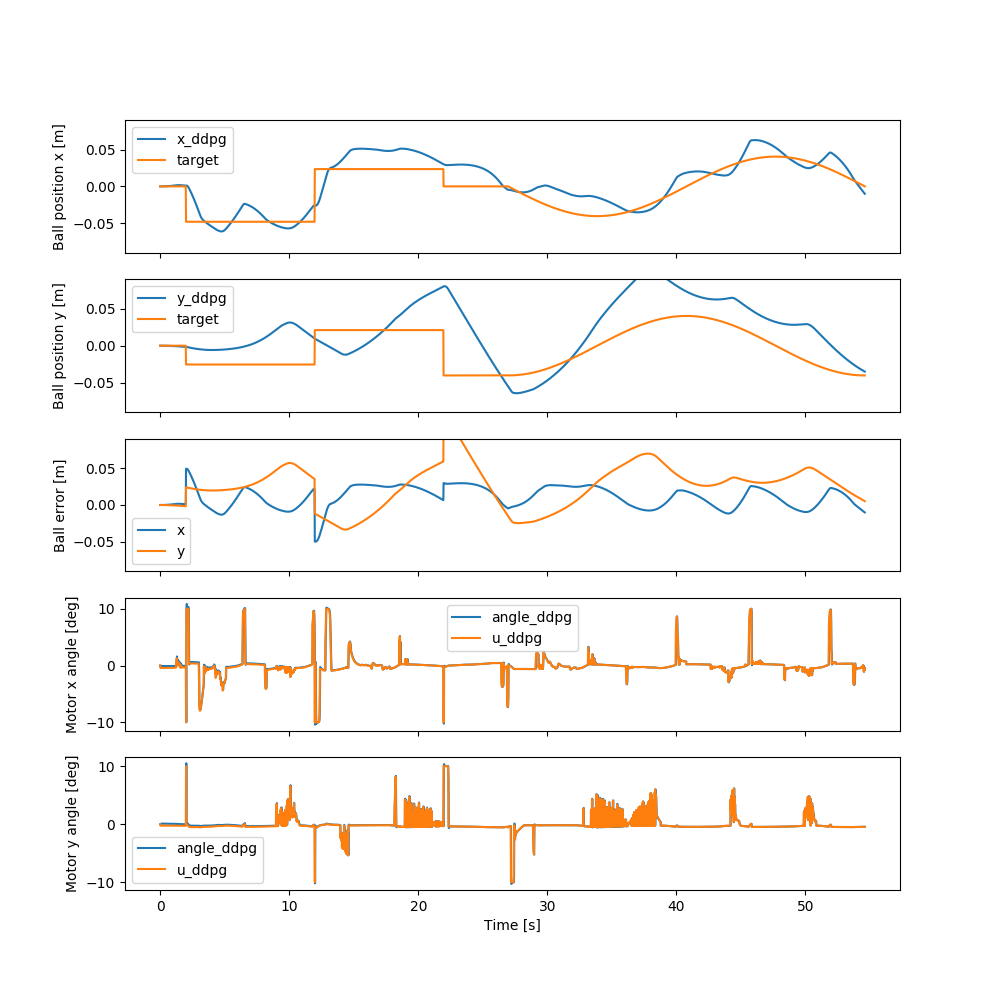

In [32]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100,50]
activation = torch.nn.ReLU
name='lep_0.6_[100,50]_relu_hard'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0., 0.]), array([0., 0.]), array([0., 0.]))
MSE : -0.000316180171608792


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


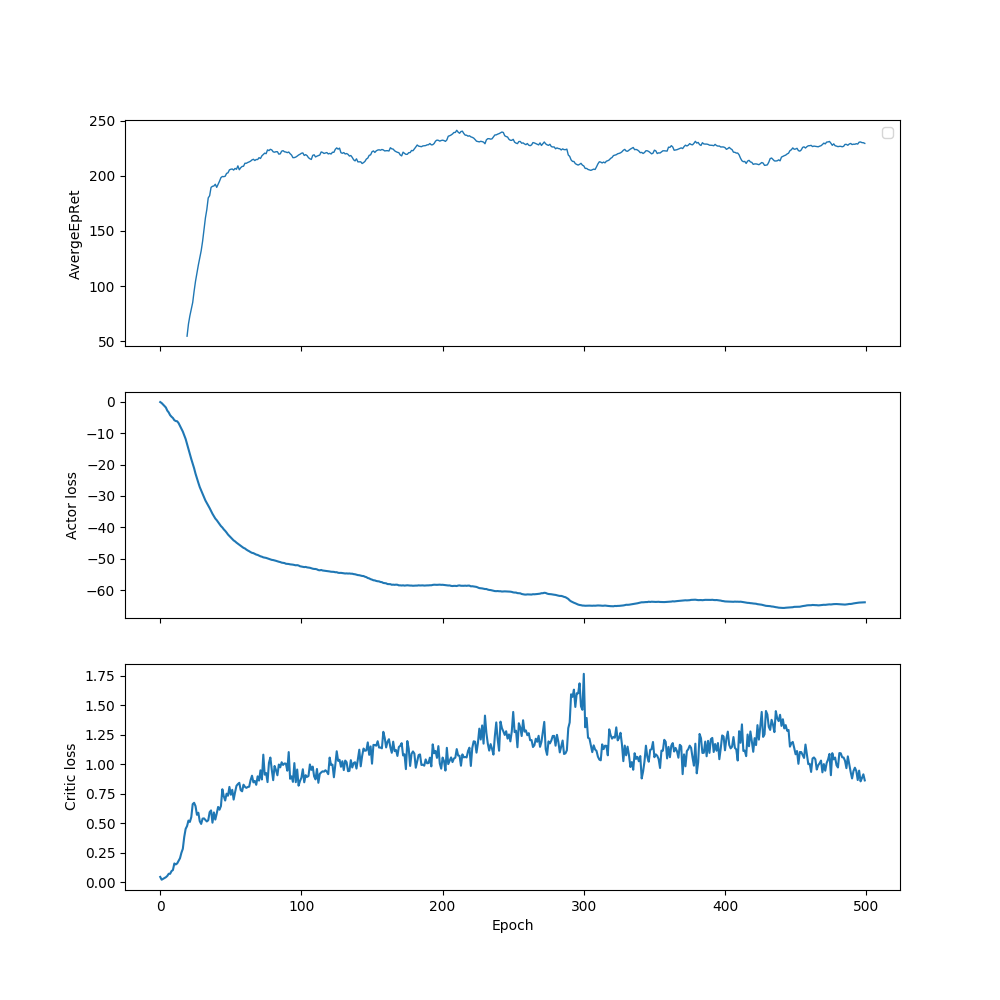

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


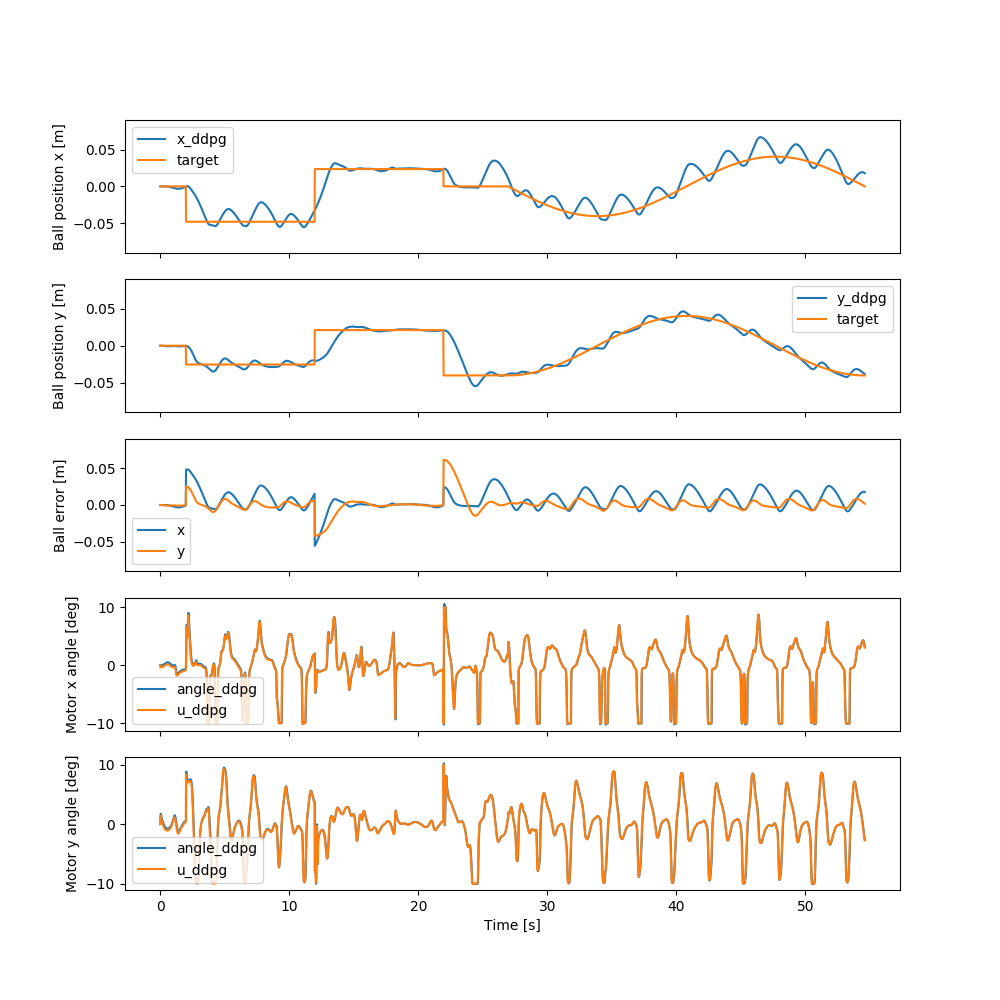

In [33]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100,50,25]
activation = torch.nn.Sigmoid
name='lep_0.6_[100,50,25]_sigmoid_hard_long'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0., 0.]), array([0., 0.]), array([0., 0.]))
MSE : -0.0002967408074543564


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


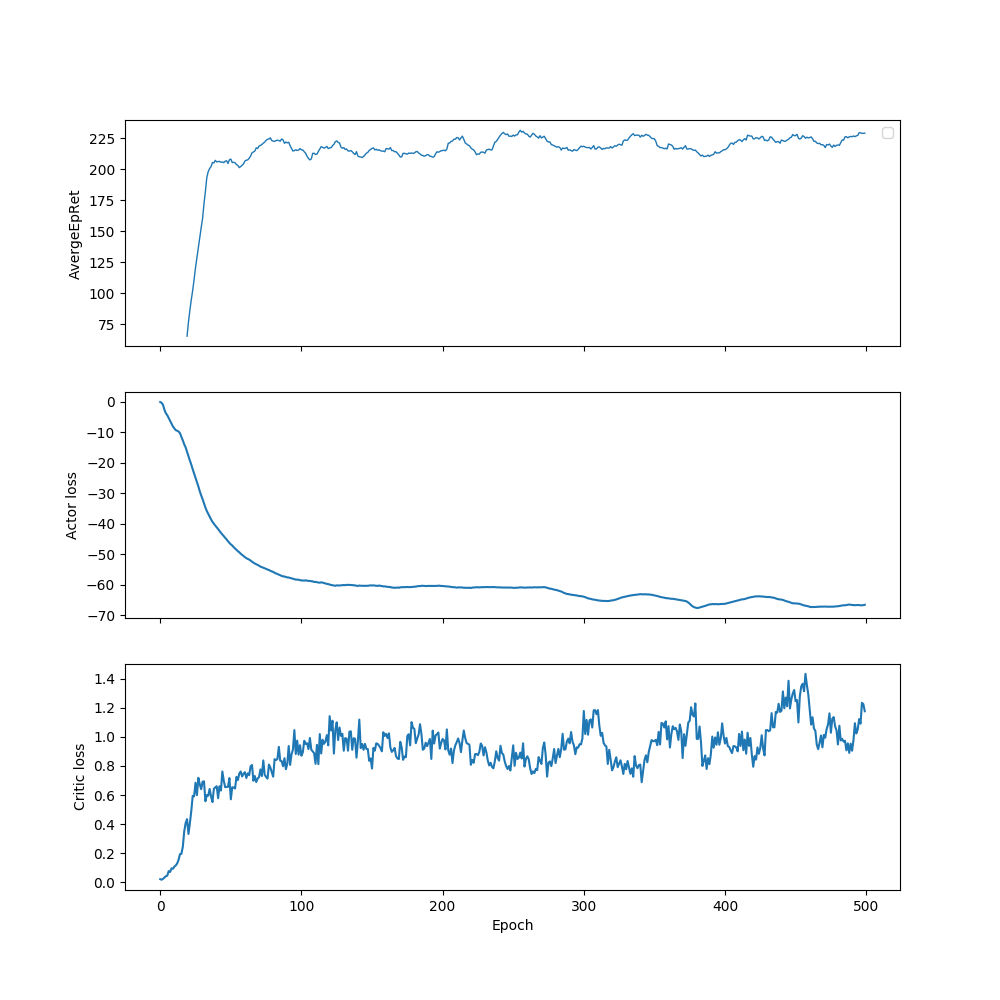

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


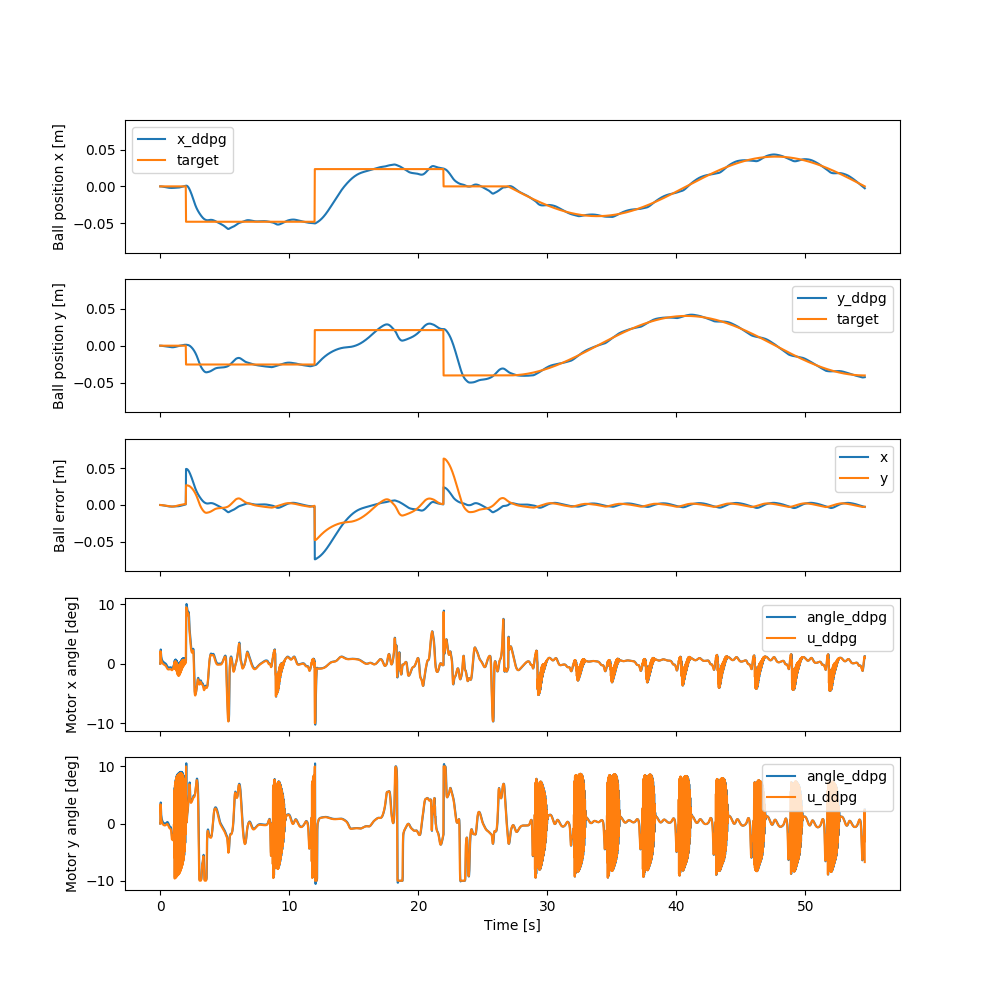

In [34]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [400,200]
activation = torch.nn.Sigmoid
name='lep_0.6_[400,200]_sigmoid_hard_long'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0., 0.]), array([0., 0.]), array([0., 0.]))
MSE : -0.0002967408074543564


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


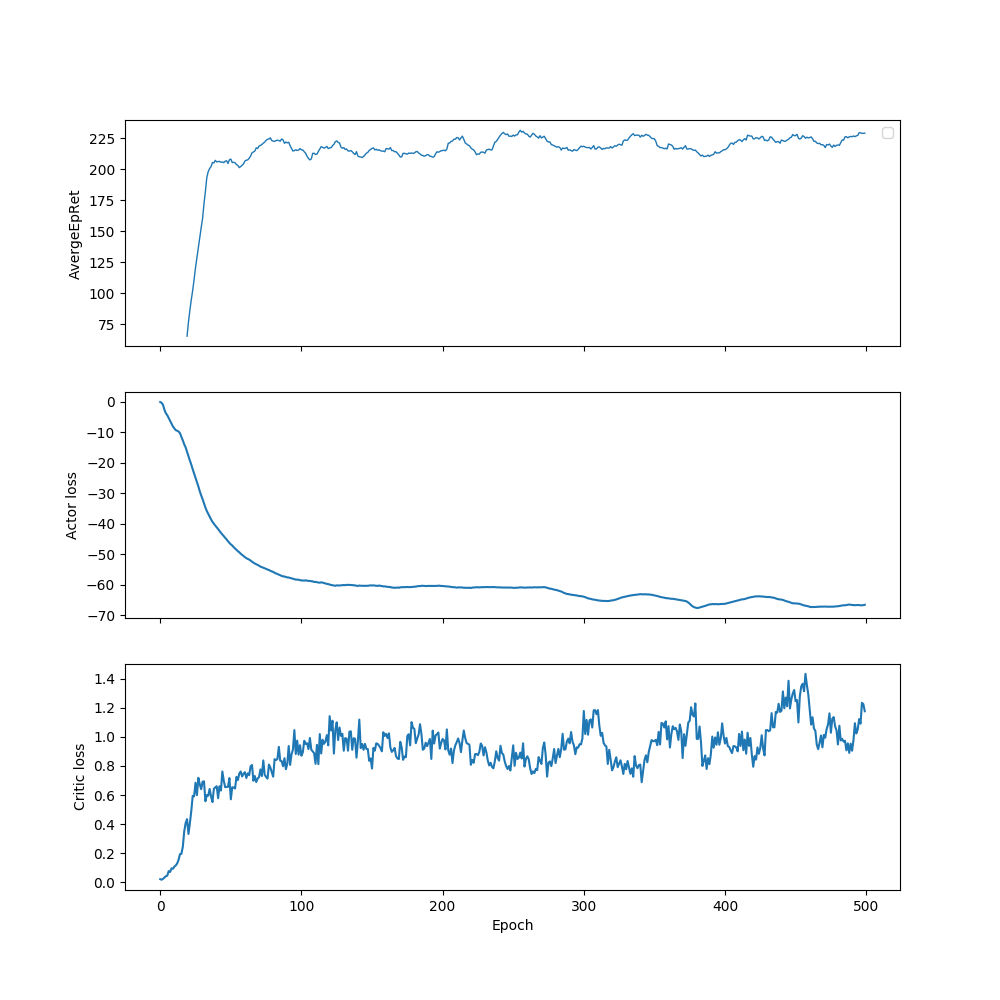

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


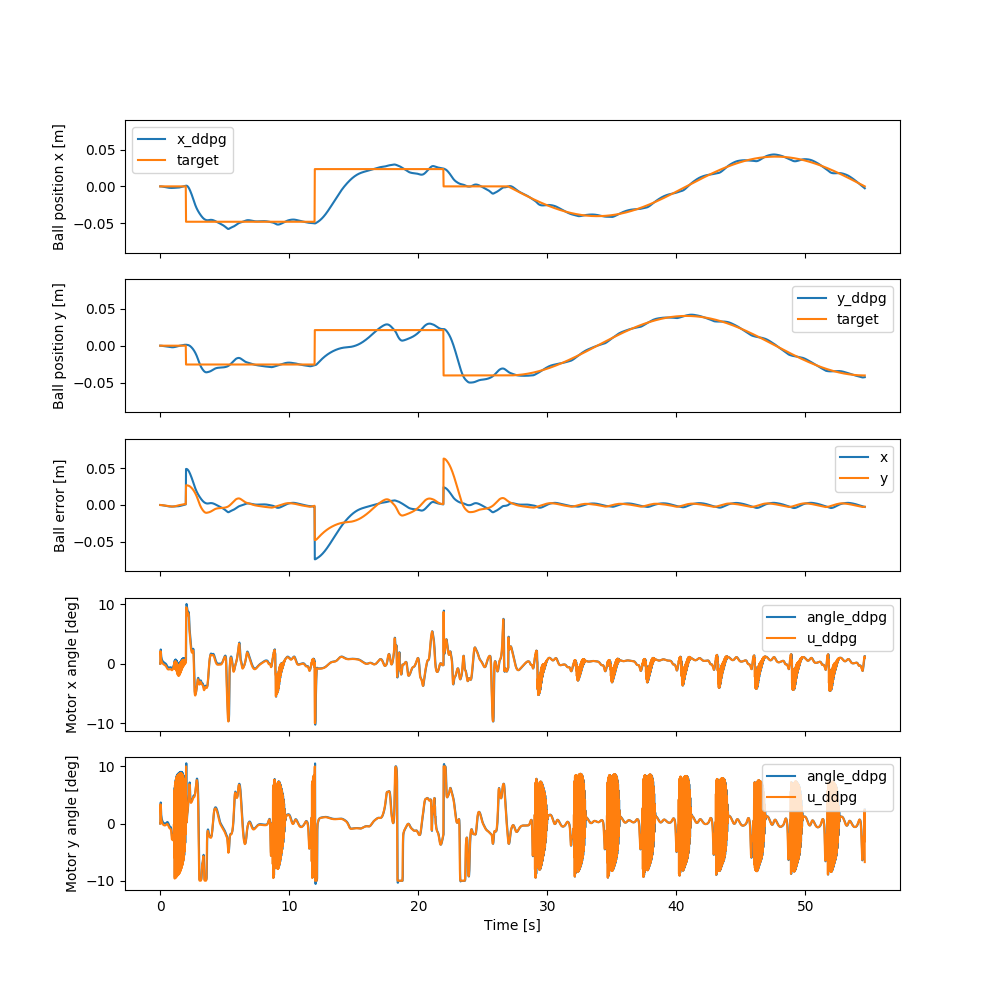

In [35]:
env = BBEnvNoIntegral
ac = MLPActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [800,400]
activation = torch.nn.Sigmoid
name='lep_0.6_[400,200]_sigmoid_hard_long'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)